In [1]:
# importations des librairies

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np


sns.plotting_context("talk")
# sns.set_palette("Dark2")

urlFig = './graph/'

# Vérification des tables

In [2]:
# Lecture des fichiers
produit = pd.read_csv("./data/products.csv")
client = pd.read_csv("./data/customers.csv")
vente = pd.read_csv("./data/transactions.csv")

# Produit

In [3]:
# Vérification de la table produit
print(produit.head(5))

  id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0


In [4]:
# Vérification des variables de la table produit
print(produit.shape)
print(produit.describe(include='all'))

(3287, 3)
       id_prod        price        categ
count     3287  3287.000000  3287.000000
unique    3287          NaN          NaN
top     0_1421          NaN          NaN
freq         1          NaN          NaN
mean       NaN    21.856641     0.370246
std        NaN    29.847908     0.615387
min        NaN    -1.000000     0.000000
25%        NaN     6.990000     0.000000
50%        NaN    13.060000     0.000000
75%        NaN    22.990000     1.000000
max        NaN   300.000000     2.000000


'id_prod' est bel et bien une clé primaire, car ils sont tous uniques.

Cependant, on peut remarquer que certains prix sont négatifs

In [5]:
# On vérifie quels sont les prix négatifs
print(produit.sort_values(by='price'))

     id_prod   price  categ
731      T_0   -1.00      0
2355   0_202    0.62      0
2272   0_528    0.62      0
370    0_120    0.66      0
1211  0_1844    0.77      0
...      ...     ...    ...
2779    2_30  233.54      2
1436   2_167  236.99      2
394    2_158  247.22      2
724     2_76  254.44      2
947      2_2  300.00      2

[3287 rows x 3 columns]


On voit que le prix négatif correspond au produit 'T_0'

In [6]:
# On retire les prix négatifs
produit = produit[produit['id_prod'] != 'T_0']
print(produit.shape)
print(produit.describe(include='all'))

(3286, 3)
       id_prod        price        categ
count     3286  3286.000000  3286.000000
unique    3286          NaN          NaN
top     0_1421          NaN          NaN
freq         1          NaN          NaN
mean       NaN    21.863597     0.370359
std        NaN    29.849786     0.615446
min        NaN     0.620000     0.000000
25%        NaN     6.990000     0.000000
50%        NaN    13.075000     0.000000
75%        NaN    22.990000     1.000000
max        NaN   300.000000     2.000000


In [7]:
# On vérifie comment est codée la catégorie
print("Les différentes valeurs de la colonne categ sont :",produit.categ.unique())

Les différentes valeurs de la colonne categ sont : [0 1 2]


# Client

In [8]:
# On regarde la table client
client.sample(5)

,client_id,sex,birth
7871,c_6858,f,1971
1617,c_6335,f,1995
8100,c_4035,f,1999
515,c_4793,f,1988
4468,c_3995,m,2004


In [9]:
# Vérification des variables de la table client
print(client.shape)
print(client.describe(include='all'))

(8623, 3)
       client_id   sex        birth
count       8623  8623  8623.000000
unique      8623     2          NaN
top       c_4410     f          NaN
freq           1  4491          NaN
mean         NaN   NaN  1978.280877
std          NaN   NaN    16.919535
min          NaN   NaN  1929.000000
25%          NaN   NaN  1966.000000
50%          NaN   NaN  1979.000000
75%          NaN   NaN  1992.000000
max          NaN   NaN  2004.000000


'client_id' est aussi une clé primaire pour les mêmes conditions

In [10]:
# Vérification de comment est codé le sexe
print("Les différentes valeurs de la colonne sex sont :",client.sex.unique())

Les différentes valeurs de la colonne sex sont : ['f' 'm']


# Vente

In [11]:
# Vérification de la table vente
print(vente.head(5))

  id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232


On retire les lignes de test

In [12]:
# Suppression des lignes établies comme test précédent
vente = vente.drop(vente[vente.id_prod == 'T_0'].index)
vente['date'] = pd.to_datetime(vente['date'], format='%Y-%m-%d')

In [13]:
# Vérification des variables de la table vente
print(vente.shape)
print(vente.describe(include='all',datetime_is_numeric=True))

(679332, 4)
       id_prod                           date session_id client_id
count   679332                         679332     679332    679332
unique    3266                            NaN     342315      8600
top      1_369                            NaN   s_118668    c_1609
freq      2252                            NaN         14     25488
mean       NaN  2022-03-03 15:13:19.307389696        NaN       NaN
min        NaN     2021-03-01 00:01:07.843138        NaN       NaN
25%        NaN  2021-09-08 09:14:25.055994368        NaN       NaN
50%        NaN  2022-03-03 07:50:20.817730560        NaN       NaN
75%        NaN  2022-08-30 23:57:08.555173888        NaN       NaN
max        NaN     2023-02-28 23:58:30.792755        NaN       NaN


# Fusion des Tables

In [14]:
# On fusionne les 3 tables
tableTotale = pd.merge(vente, produit, on='id_prod', how='left')
tableTotale = pd.merge(tableTotale, client, on='client_id', how='left')

print(f' vente shape is :{vente.shape}')
print(f' produit shape is :{produit.shape}')
print(f' client shape is :{client.shape}')
print(f' tableTotale shape is :{tableTotale.shape}')

 vente shape is :(679332, 4)
 produit shape is :(3286, 3)
 client shape is :(8623, 3)
 tableTotale shape is :(679332, 8)


In [15]:
# Vérification des variables de la table obtenue
print(tableTotale.shape)
print(tableTotale.describe(include='all', datetime_is_numeric=True))

(679332, 8)
       id_prod                           date session_id client_id  \
count   679332                         679332     679332    679332   
unique    3266                            NaN     342315      8600   
top      1_369                            NaN   s_118668    c_1609   
freq      2252                            NaN         14     25488   
mean       NaN  2022-03-03 15:13:19.307389696        NaN       NaN   
min        NaN     2021-03-01 00:01:07.843138        NaN       NaN   
25%        NaN  2021-09-08 09:14:25.055994368        NaN       NaN   
50%        NaN  2022-03-03 07:50:20.817730560        NaN       NaN   
75%        NaN  2022-08-30 23:57:08.555173888        NaN       NaN   
max        NaN     2023-02-28 23:58:30.792755        NaN       NaN   
std        NaN                            NaN        NaN       NaN   

                price          categ     sex          birth  
count   679111.000000  679111.000000  679332  679332.000000  
unique            NaN  

On remarque qu'il y a des prix et des catégories qui ne sont pas renseignées

In [16]:
# Identification des prix non renseignés
print(tableTotale[tableTotale['price'].isna()]['id_prod'].unique())

['0_2245']


In [17]:
# Vérification de la table produit pour savoir d'où vient l'erreur
print(produit[produit['id_prod'] == '0_2245'].shape)

(0, 3)


In [18]:
# Vérification de la table vente pour savoir d'où vient l'erreur
print(vente[vente['id_prod'] == '0_2245'].shape)

(221, 4)


Ce produit n'apparait pas dans la table produit ce qui explique qui ne possède ni prix ni catégorie, pourtant il a été vendu 221 fois. Sur les 658664 ventes ce nombre est négligeable. D'autant plus si on remarque que le premier nombre de l'id produit correspond à la catégorie et que la catégorie 0 est la catégorie avec les prix les moins chères en moyenne.

In [19]:
# Suppression des lignes contenant ce produit
tableTotale = tableTotale[tableTotale['id_prod'] != '0_2245']

# Calcul du chiffre d'affaires

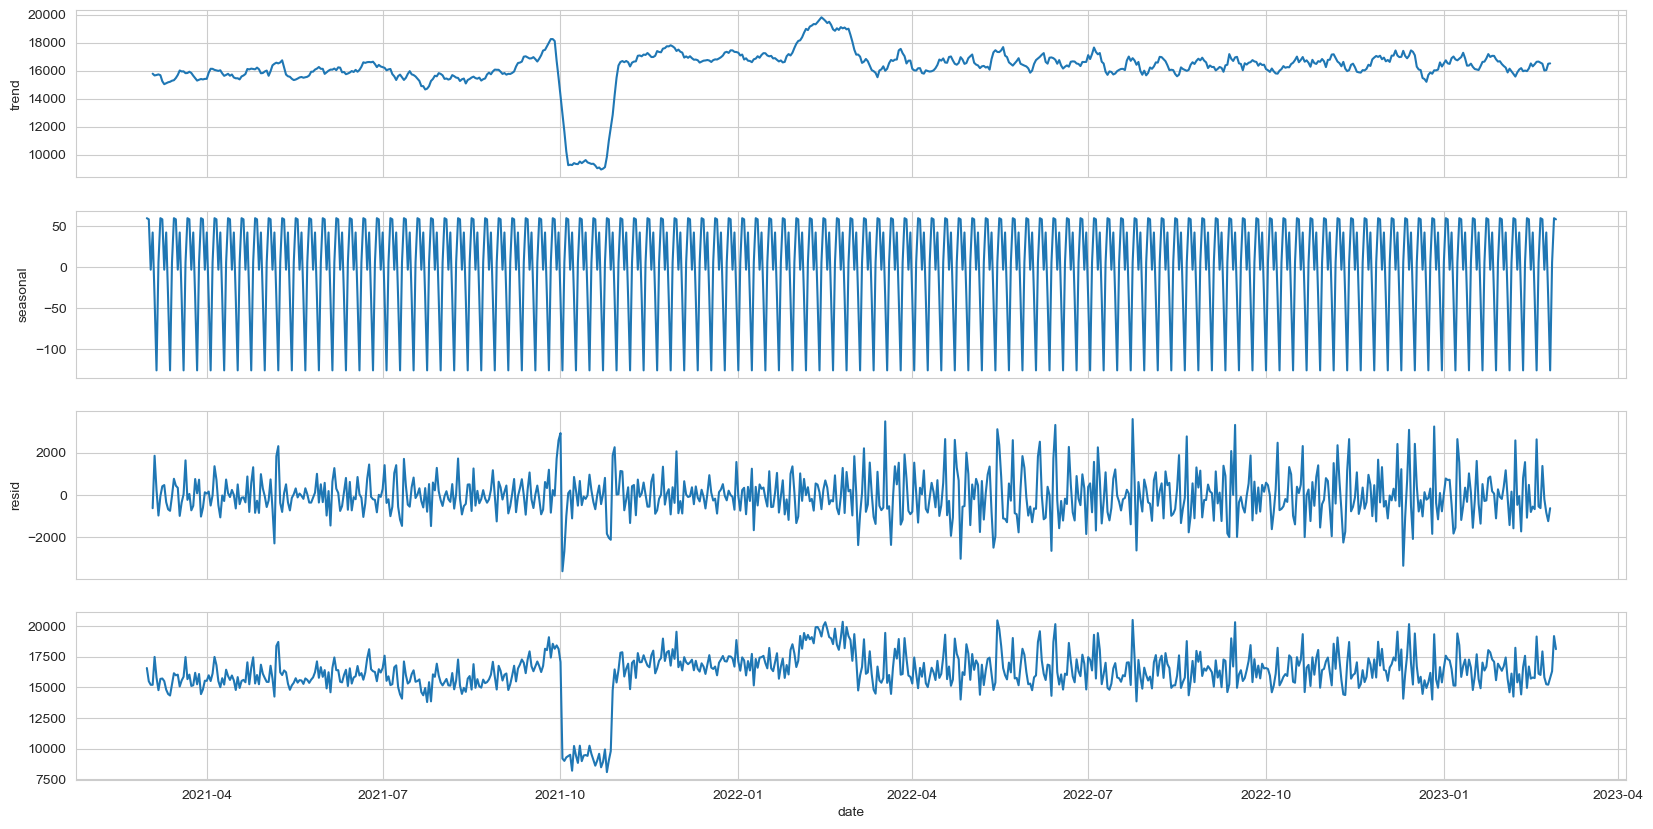

In [20]:
# Calcul de la moyenne mobile du chiffre d'affaires
chiffreAffaireJournalier = tableTotale[['price', 'date']].resample('D', on='date').sum()

result = seasonal_decompose(chiffreAffaireJournalier[['price']], model='additive')

f, (axTrend, axSeasonal, axResid, axObs) = plt.subplots(4, 1, figsize=(20, 10), sharex=True)


sns.lineplot(data=result.trend, ax=axTrend)
sns.lineplot(data=result.seasonal, ax=axSeasonal)
sns.lineplot(data=result.resid, ax=axResid)
sns.lineplot(data=result.observed, ax=axObs)

plt.savefig(urlFig + "Moyenne mobile du chiffre d'affaires (avant suppression des données).png", dpi=300)

On se rend compte qu'il manque des données sur le mois d'octobre 2021

# Nombre de Ventes par catégorie

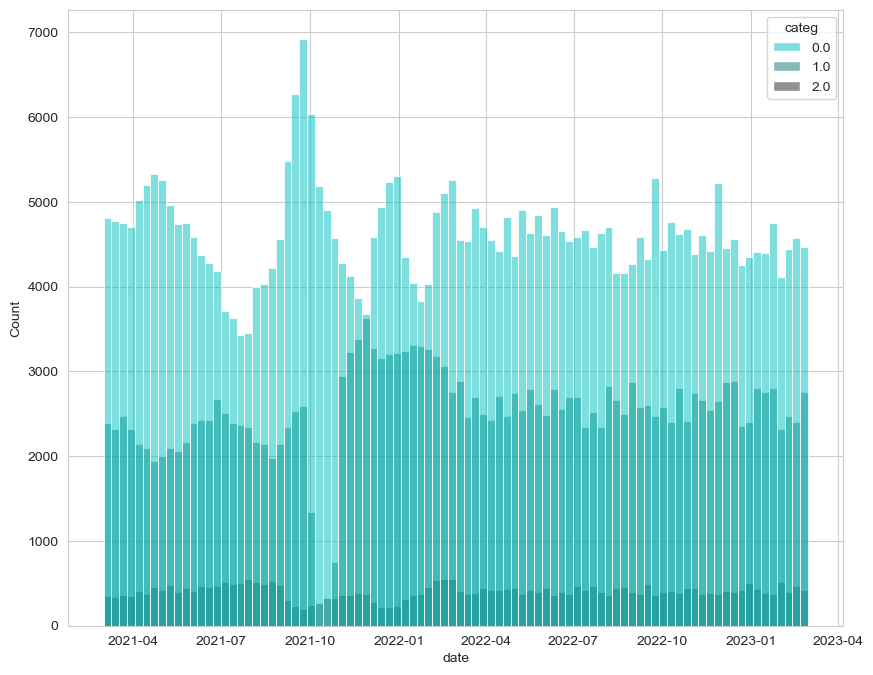

In [21]:
# Affichage du nombre de ventes par catégorie
plt.figure(figsize=(10,8))
sns.histplot(data=tableTotale, x='date', hue='categ',palette="dark:c_r")
plt.savefig(urlFig + "Histogramme du nombre de ventes par catégorie (avant suppression des données).png", dpi=300)



Comme on peut le voir, ce sont les données sur les ventes de livres de catégorie 1 qu'il manque. On va donc complétement effacer les données du mois d'octobre 2021.

In [22]:
# Suppression des données du mois d'octobre
tailleAv = len(tableTotale.index)
tableTotale = tableTotale.loc[tableTotale['date'].dt.strftime('%Y%m') != pd.Timestamp(year=2021, month=10, day=1).strftime('%Y%m')]
tailleAp = len(tableTotale.index)

print("on a supprimé",tailleAv-tailleAp,"lignes, soit",round(((tailleAv-tailleAp)/tailleAv)*100,2),"% du dataframe original.")

on a supprimé 21599 lignes, soit 3.18 % du dataframe original.


# Calcul du nouveau chiffre d'affaires

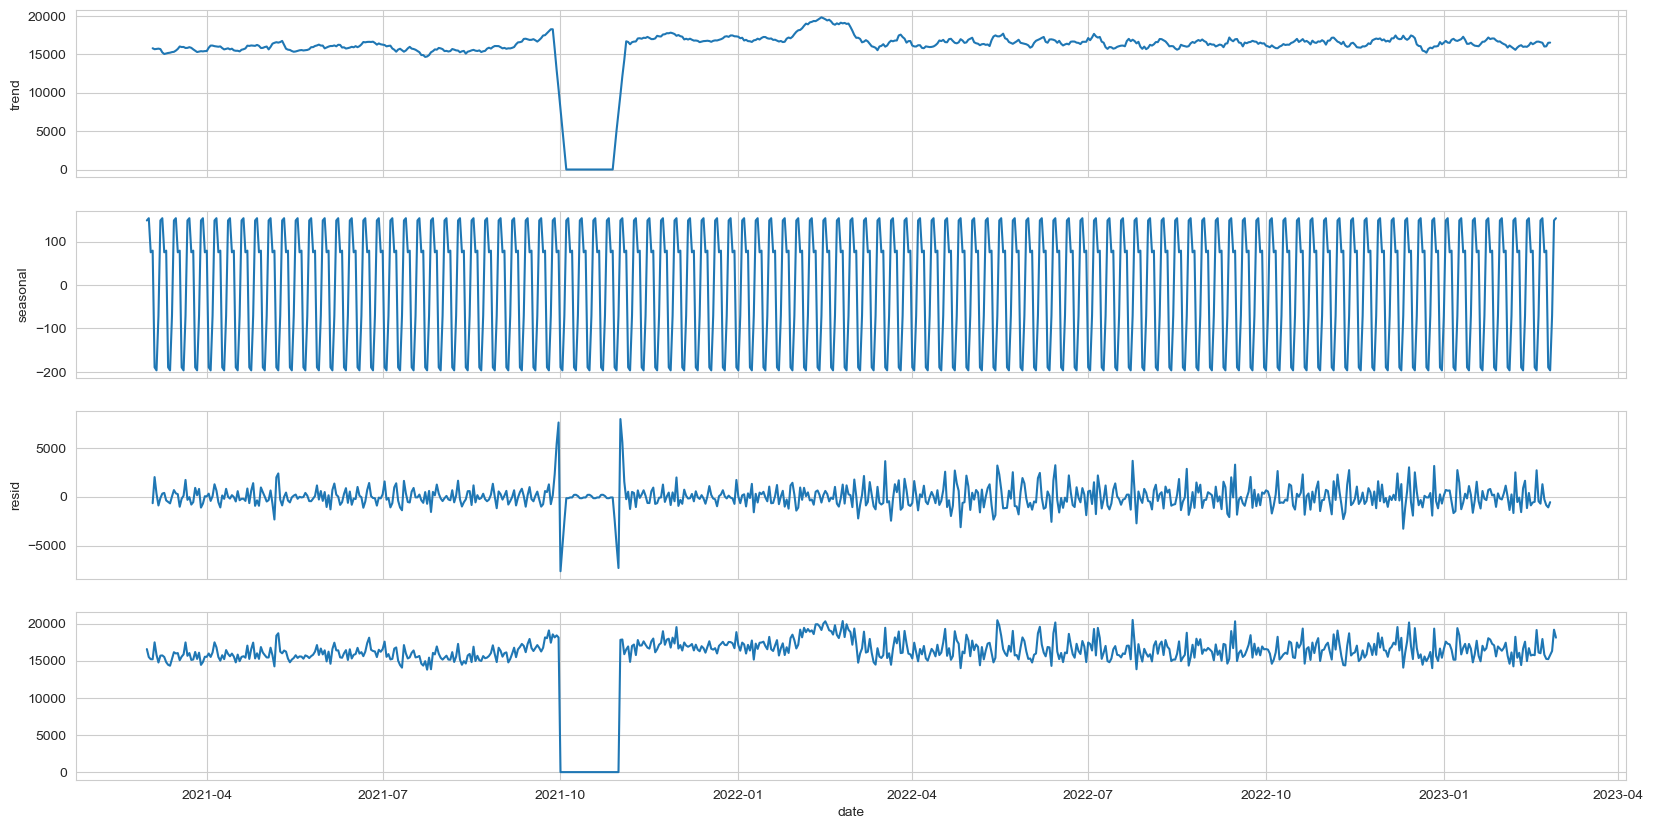

In [23]:
# Calcul de la nouvelle moyenne mobile du chiffre d'affaires 
chiffreAffaireJournalier = tableTotale[['price', 'date']].resample('D', on='date').sum()


result = seasonal_decompose(chiffreAffaireJournalier[['price']], model='additive')

f,(axTrend, axSeasonal, axResid, axObs) = plt.subplots(4,1,figsize=(20,10),sharex=True)


sns.lineplot(data=result.trend, ax=axTrend)
sns.lineplot(data=result.seasonal, ax=axSeasonal)
sns.lineplot(data=result.resid, ax=axResid)
sns.lineplot(data=result.observed, ax=axObs)

plt.savefig(urlFig + "Moyenne mobile du chiffre d'affaires (après suppression des données).png", dpi=300)


On recolle les données entre elles afin d'avoir une série de données continue

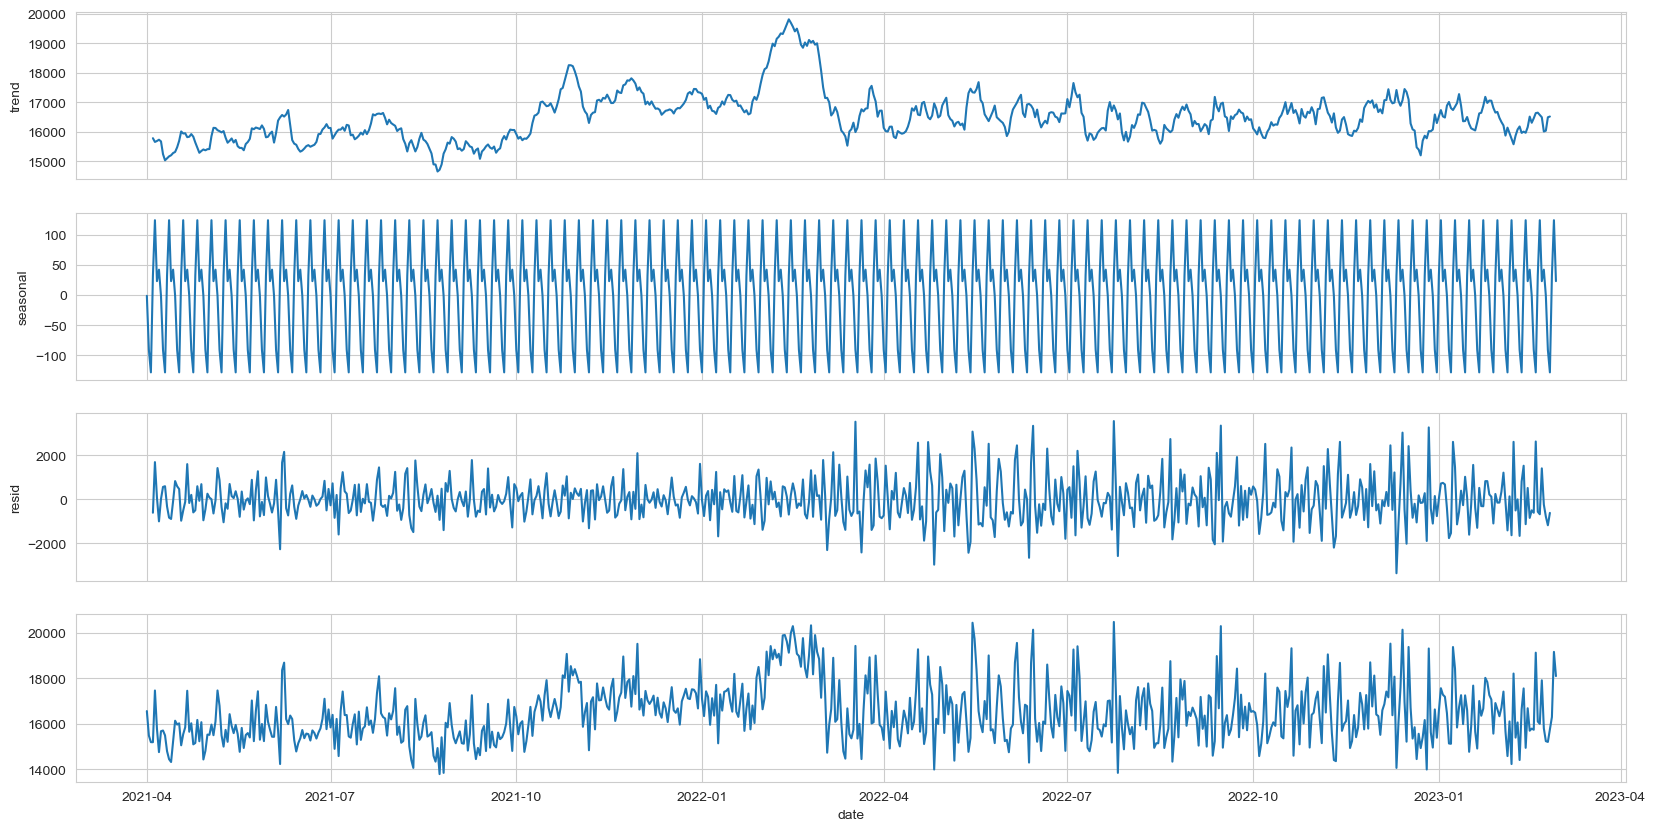

In [24]:
# Recollage des données afin de supprimer la discontinuité
tempo = tableTotale.copy(deep=True)

tempo['date'] = np.where(tempo['date']<'2021-10-1',
                                           tempo['date'] +  pd.DateOffset(days=31),
                                           tempo['date'])

chiffreAffaireJournalierContinue = tempo[['price', 'date']].resample('D', on='date').sum()

result = seasonal_decompose(chiffreAffaireJournalierContinue[['price']], model='additive')

f,(axTrend, axSeasonal, axResid, axObs) = plt.subplots(4,1,figsize=(20,10),sharex=True)


sns.lineplot(data=result.trend, ax=axTrend)
sns.lineplot(data=result.seasonal, ax=axSeasonal)
sns.lineplot(data=result.resid, ax=axResid)
sns.lineplot(data=result.observed, ax=axObs)

plt.savefig(urlFig + "Moyenne mobile du chiffre d'affaires (après suppression des données et recollage).png", dpi=300)

# Nouvelles ventes par catégorie

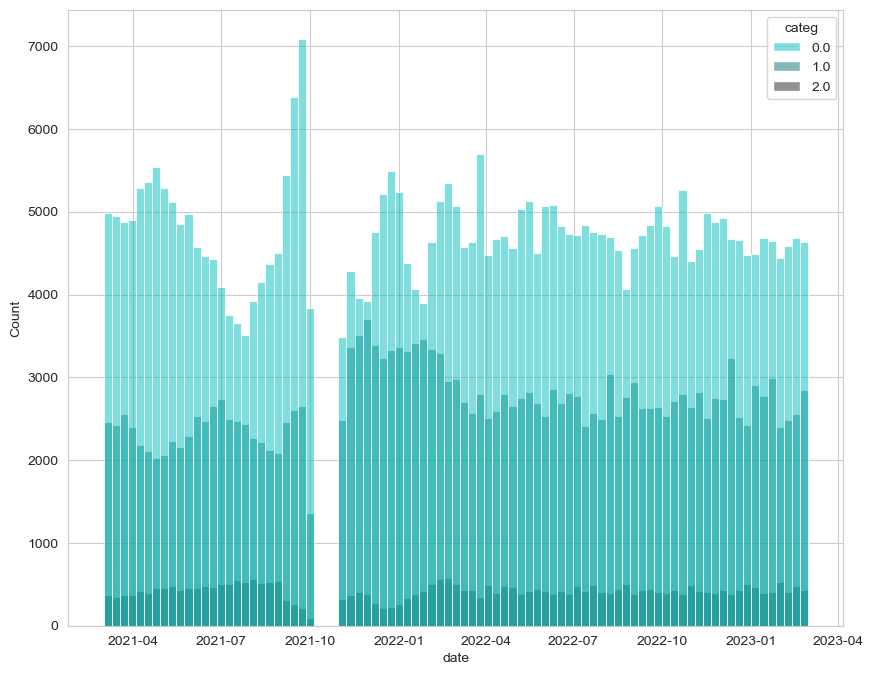

In [25]:
# Affichage du nouveau nombre de ventes par catégorie
plt.figure(figsize=(10,8))
sns.histplot(data=tableTotale, x='date', hue='categ',palette="dark:c_r")

plt.savefig(urlFig + "Histogramme du nombre de ventes par catégorie (après suppression des données).png", dpi=300)

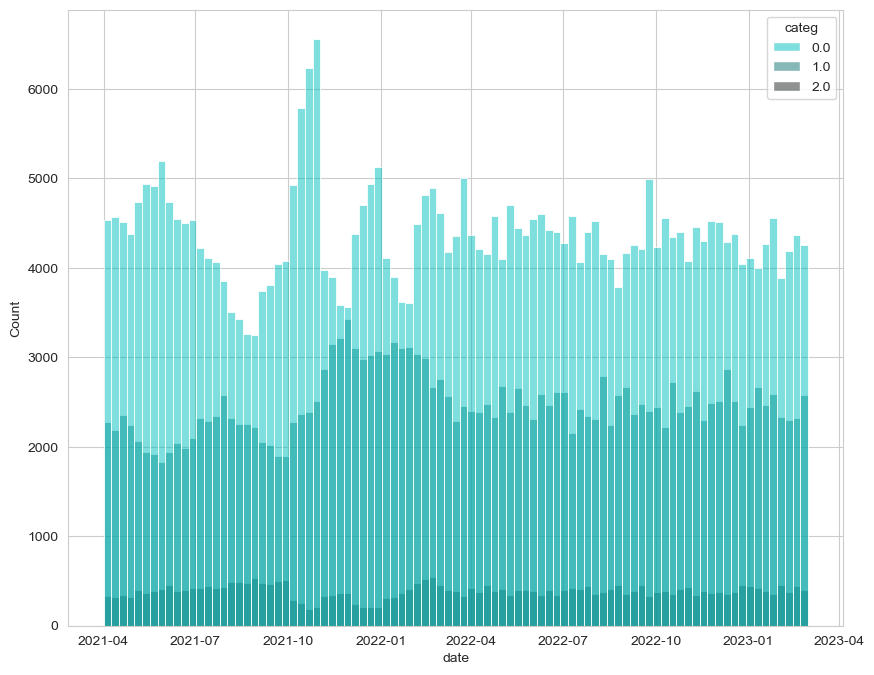

In [26]:
# Affichage du nouveau nombre de ventes par catégorie
plt.figure(figsize=(10,8))
sns.histplot(data=tempo, x='date', hue='categ',palette="dark:c_r")

plt.savefig(urlFig + "Histogramme du nombre de ventes par catégorie (après suppression des données et recollage).png", dpi=300)

# Ajout de nouvelles colonnes

Création d'une tranche d'âge

In [27]:
# Création d'une fonction permettant d'arrondir un chiffre à la dizaine inférieur
def arrondiNInf(x, n:int):
    x = int(x)
    while x%n !=0:
        x=x-1
    return x

In [28]:
# Calcul de l'âge en fonction de la date d'achat
tableTotale['age'] = pd.DatetimeIndex(tableTotale['date']).year - tableTotale['birth']

In [29]:
# Création de la tranche d'âge
inter = 10
tableTotale['trancheAge'] = tableTotale['age'].apply(arrondiNInf,n=inter).apply(str)\
                            +'-'\
                            +(tableTotale['age'].apply(arrondiNInf,n=inter)+inter).apply(str)


In [30]:
# Vérification de la table
print(tableTotale.shape)
print(tableTotale.describe(include='all', datetime_is_numeric=True))

(657512, 10)
       id_prod                           date session_id client_id  \
count   657512                         657512     657512    657512   
unique    3263                            NaN     330731      8598   
top      1_369                            NaN   s_118668    c_1609   
freq      2237                            NaN         14     24472   
mean       NaN  2022-03-08 03:59:26.060106240        NaN       NaN   
min        NaN     2021-03-01 00:01:07.843138        NaN       NaN   
25%        NaN  2021-09-02 21:01:11.439571456        NaN       NaN   
50%        NaN     2022-03-14 23:06:31.924672        NaN       NaN   
75%        NaN  2022-09-05 21:29:50.094605568        NaN       NaN   
max        NaN     2023-02-28 23:58:30.792755        NaN       NaN   
std        NaN                            NaN        NaN       NaN   

                price          categ     sex          birth            age  \
count   657512.000000  657512.000000  657512  657512.000000  657512.

On ajoute le prix du panier ainsi que le panier moyen par client.

In [31]:
# Ajout du montant moyen du panier par client
tableTotale = tableTotale.merge(
    tableTotale.groupby('session_id')['price'].sum().reset_index(),
    how='left', on='session_id').rename(columns={'client_id_x': 'client_id','price_x': 'price','price_y': 'montantPanier'})

tableTotale.sort_values(by='session_id',ascending=False)

tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id')['montantPanier'].mean().reset_index(),
    how='left', on='client_id').rename(columns={'montantPanier_x': 'montantPanier','montantPanier_y': 'montantPanierMoyen'})

tableTotale.sort_values(by='session_id',ascending=False)

tableTotale['montantPanierMoyen'] = tableTotale['montantPanierMoyen'].round(decimals=2)

On ajoute la taille du panier ainsi que la taille moyenne du panier par client.

In [32]:
# Ajout de la taille moyenne du panier par client
tableTotale = tableTotale.merge(
    tableTotale.groupby('session_id')['client_id'].count().reset_index(),
    how='left', on='session_id').rename(columns={'client_id_x': 'client_id','client_id_y': 'taillePanier'})


tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id')['taillePanier'].mean().reset_index(),
    how='left', on='client_id').rename(columns={'taillePanier_x': 'taillePanier','taillePanier_y': 'taillePanierMoyen'})

tableTotale.sort_values(by='session_id',ascending=False)

tableTotale['taillePanierMoyen'] = tableTotale['taillePanierMoyen'].round(decimals=2)

On ajoute le chiffre d'affaires par client

In [33]:
# Ajout du chiffre d'affaires par client
tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id')['price'].sum().reset_index(),
    how='left', on='client_id').rename(columns={'price_x': 'price','price_y': 'chiffreAffaireClient'})

tableTotale.sort_values(by='client_id')


,id_prod,date,session_id,client_id,price,categ,sex,birth,age,trancheAge,montantPanier,montantPanierMoyen,taillePanier,taillePanierMoyen,chiffreAffaireClient
600822,1_425,2021-12-25 03:53:43.623598,s_139610,c_1,16.99,1.0,m,1955,66,60-70,16.99,26.56,1,1.63,550.19
518641,0_1571,2022-02-01 01:47:04.355850,s_158128,c_1,5.99,0.0,m,1955,67,60-70,5.99,26.56,1,1.63,550.19
472811,0_513,2022-12-21 22:41:38.769525,s_315508,c_1,11.99,0.0,m,1955,67,60-70,11.99,26.56,1,1.63,550.19
308637,0_1880,2021-11-04 18:37:01.482109,s_114737,c_1,14.91,0.0,m,1955,66,60-70,92.62,26.56,5,1.63,550.19
177936,0_1448,2021-07-26 17:37:29.438136,s_67467,c_1,18.94,0.0,m,1955,66,60-70,18.94,26.56,1,1.63,550.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51091,1_676,2023-02-10 23:59:59.414026,s_339757,c_999,19.50,1.0,m,1964,59,50-60,19.50,19.67,1,1.18,681.43
578055,0_1426,2022-07-10 02:44:13.556163,s_236171,c_999,13.44,0.0,m,1964,58,50-60,13.44,19.67,1,1.18,681.43
453278,0_1426,2022-06-10 02:44:13.556163,s_221433,c_999,13.44,0.0,m,1964,58,50-60,13.44,19.67,1,1.18,681.43
262226,1_395,2022-08-23 16:44:27.072834,s_257401,c_999,28.99,1.0,m,1964,58,50-60,28.99,19.67,1,1.18,681.43


On ajoute le jour auquel a été faite la transaction

In [34]:
# Ajout du jour auquel a été fait l'achat
tableTotale['jour'] = tableTotale['date'].dt.day_name()

Ljour = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

tableTotale['jour'] = pd.Categorical(tableTotale['jour'], ordered=True,
               categories=Ljour)

In [78]:
tableTotale.sort_values(by=['trancheAge','date'])

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,trancheAge,...,taillePanierMoyen,chiffreAffaireClient,jour,nombre d'achats,date_inscription,ventes_mensuelles,nomférié,férié,saison,anormal
529713,0_1593,2021-03-01 00:48:54.344359,s_24,c_6133,6.99,0.0,m,2004,17,10-20,...,2.49,1402.41,Monday,51,2021-04-01 00:48:54.344359,2.19,Aucun,Aucun,Printemps,Client 'Normal'
455682,1_362,2021-03-01 00:51:27.394369,s_24,c_6133,11.25,1.0,m,2004,17,10-20,...,2.49,1402.41,Monday,51,2021-04-01 00:48:54.344359,2.19,Aucun,Aucun,Printemps,Client 'Normal'
239132,2_153,2021-03-01 00:59:26.743244,s_29,c_2627,139.99,2.0,m,2004,17,10-20,...,2.35,3735.25,Monday,101,2021-04-01 00:59:26.743244,4.34,Aucun,Aucun,Printemps,Client 'Normal'
210243,1_397,2021-03-01 01:25:13.688519,s_29,c_2627,18.99,1.0,m,2004,17,10-20,...,2.35,3735.25,Monday,101,2021-04-01 00:59:26.743244,4.34,Aucun,Aucun,Printemps,Client 'Normal'
563721,0_1591,2021-03-01 01:30:39.840972,s_24,c_6133,9.99,0.0,m,2004,17,10-20,...,2.49,1402.41,Monday,51,2021-04-01 00:48:54.344359,2.19,Aucun,Aucun,Printemps,Client 'Normal'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110494,0_1072,2023-02-24 15:39:32.825287,s_346317,c_4334,14.82,0.0,m,1931,92,90-100,...,3.87,632.40,Friday,46,2021-04-06 15:41:04.821518,1.99,Aucun,Aucun,Hiver,Client 'Normal'
56192,1_378,2023-02-26 11:54:21.223206,s_347191,c_2741,26.61,1.0,f,1933,90,90-100,...,1.17,927.29,Sunday,60,2021-04-11 02:43:47.550155,2.62,Aucun,Aucun,Hiver,Client 'Normal'
483120,0_1061,2023-02-26 11:54:36.872826,s_347192,c_353,19.99,0.0,m,1930,93,90-100,...,1.75,952.44,Sunday,51,2021-04-02 14:05:27.856579,2.20,Aucun,Aucun,Hiver,Client 'Normal'
84384,0_1416,2023-02-27 01:56:21.888437,s_347485,c_6154,9.56,0.0,f,1932,91,90-100,...,2.54,831.11,Monday,48,2021-04-14 14:15:27.293193,2.10,Aucun,Aucun,Hiver,Client 'Normal'


Ajout de la fréquence d'achat (nombre d'achats moyen par mois)

In [36]:
# Ajout de la fréquence d'achat par mois
max,min = tableTotale['date'].max(),tableTotale['date'].min()

nbMois = (max - min)/np.timedelta64(1, 'M')
nbMois = round(nbMois)

print("Les données s'étalent sur", nbMois,"mois,",nbMois-1, "si on ne prend pas en compte le mois d'octobre")

Les données s'étalent sur 24 mois, 23 si on ne prend pas en compte le mois d'octobre


On ajoute la fréquence d'achat en ignorant le mois d'octobre

In [37]:
# Ajout du nombre d'achats total
tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id').count()['date'].reset_index().rename(columns={'date': 'nombre d\'achats'}),
    how='left', on='client_id')

tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id')['date'].agg(['min']).reset_index().rename(columns={'min': 'date_inscription'}),
    how='left', on='client_id')

tableTotale['date_inscription'] = np.where(tableTotale['date_inscription']<'2021-10-15',
                                           tableTotale['date_inscription'] +  pd.DateOffset(months=1),
                                           tableTotale['date_inscription'])

tableTotale['date_inscription'] = pd.to_datetime(tableTotale['date_inscription'])
tableTotale['date'] = pd.to_datetime(tableTotale['date'])




In [38]:
# Ajout de la fréquence d'achat par mois
dateFinale = tableTotale['date'].max()

tableTotale['ventes_mensuelles'] = round(tableTotale['nombre d\'achats'] / ((dateFinale - tableTotale['date_inscription']).dt.days/30),2)

print(tableTotale.describe(datetime_is_numeric=True))
# print(tableTotale.sort_values(by='price'))

                                date          price          categ  \
count                         657512  657512.000000  657512.000000   
mean   2022-03-08 03:59:26.060106240      17.540258       0.450375   
min       2021-03-01 00:01:07.843138       0.620000       0.000000   
25%    2021-09-02 21:01:11.439571456       8.990000       0.000000   
50%       2022-03-14 23:06:31.924672      13.990000       0.000000   
75%    2022-09-05 21:29:50.094605568      19.080000       1.000000   
max       2023-02-28 23:58:30.792755     300.000000       2.000000   
std                              NaN      18.340492       0.595776   

               birth            age  montantPanier  montantPanierMoyen  \
count  657512.000000  657512.000000  657512.000000       657512.000000   
mean     1977.776570      43.915959      45.141123           45.141104   
min      1929.000000      17.000000       0.620000            4.150000   
25%      1970.000000      35.000000      21.990000           34.440000   

On ajoute une colonne qui sert à savoir si l'achat a été fait un jour ferié

In [39]:
# Ajout de si l'achat a été fait un jour férié
from jours_feries_france import JoursFeries

def estJourFérié(date):
    if JoursFeries.is_bank_holiday(date.date(), zone="Métropole"):
        return 'Oui'
    else:
        return 'Aucun'

def nomJourFérié(date):
    if JoursFeries.is_bank_holiday(date.date(), zone="Métropole"):
        return JoursFeries.next_bank_holiday(date.date(), zone="Métropole")[0]
    else:
        return 'Aucun'


tableTotale['nomférié'] = tableTotale['date'].apply(nomJourFérié)
tableTotale['férié'] = tableTotale['date'].apply(estJourFérié)

"""
tableTotale.loc[tableTotale['férié'] == 'Aucun','férié'] = None
tableTotale.loc[tableTotale['férié'] == True,'férié'] = JoursFeries.next_bank_holiday(tableTotale['date'].dt.date(), zone="Métropole")
"""

'\ntableTotale.loc[tableTotale[\'férié\'] == \'Aucun\',\'férié\'] = None\ntableTotale.loc[tableTotale[\'férié\'] == True,\'férié\'] = JoursFeries.next_bank_holiday(tableTotale[\'date\'].dt.date(), zone="Métropole")\n'

On ajoute la saison à laquelle à été fait l'achat

In [40]:
# Ajout de la saison où a été fait l'achat
def saison(mois):

    saisonMois = {
        12:'Hiver', 1:'Hiver', 2:'Hiver',
        3:'Printemps', 4:'Printemps', 5:'Printemps',
        6:'Été', 7:'Été', 8:'Été',
        9:'Automne', 10:'Automne', 11:'Automne'}

    return saisonMois.get(mois)

tableTotale['saison'] = tableTotale['date'].dt.month.apply(saison)

On supprime les colonnes : taille du panier et montant du panier devenues inutiles

In [41]:
# Suppression des colonnes : ["montantPanier", "taillePanier"]
tableTotale = tableTotale.drop(["montantPanier", "taillePanier"], axis=1, errors='ignore')


(Importance des plus grosses fréquences d'achats)

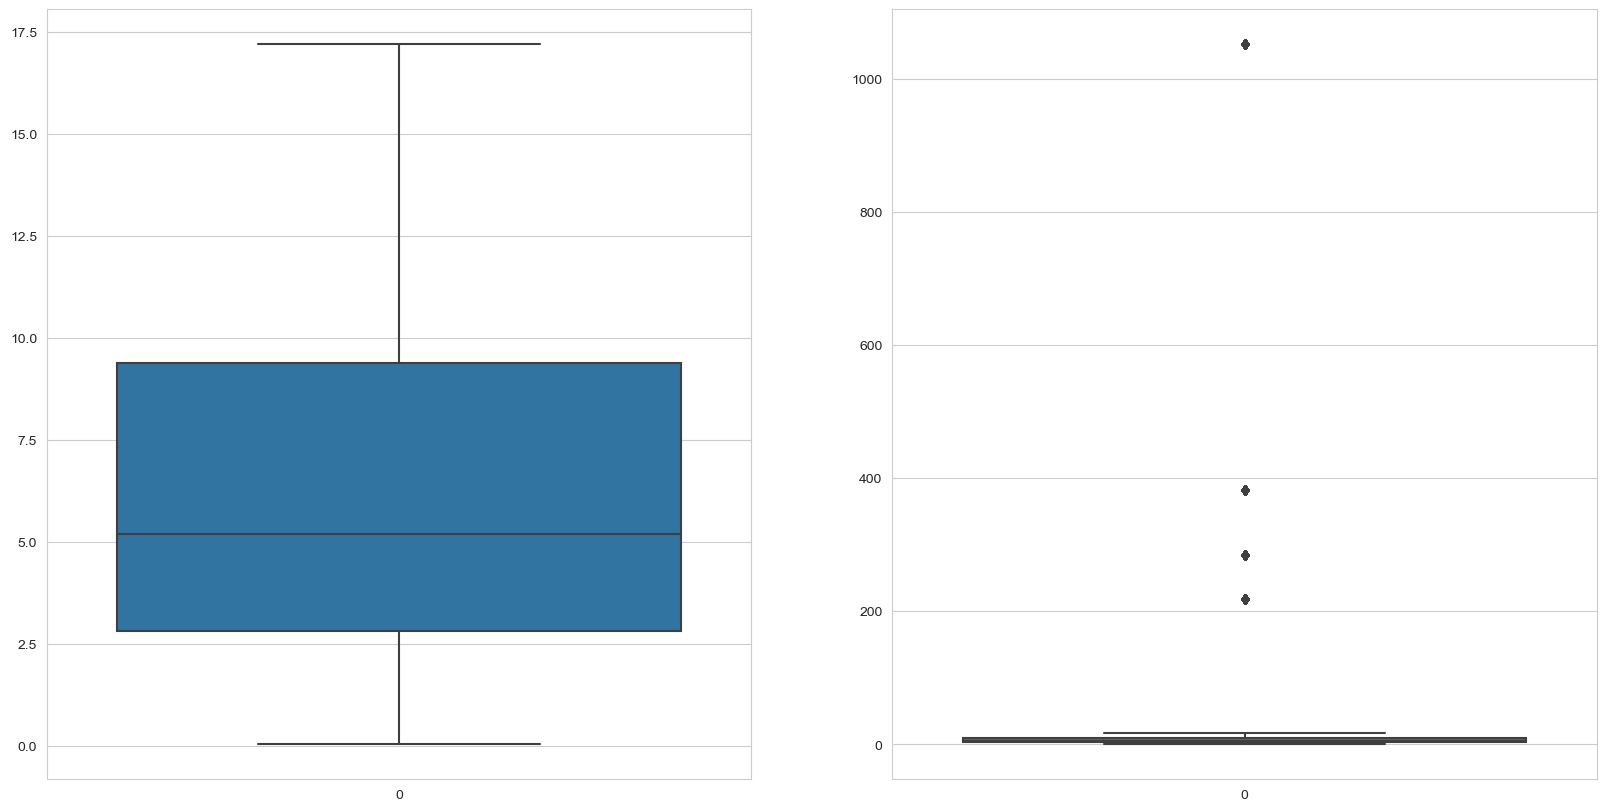

In [42]:
# Analyse des fréquence d'achats
f, (ax_box1, ax_box) = plt.subplots(nrows=1, ncols=2, sharex=False,  figsize=(20,10))
sns.boxplot(data=tableTotale['ventes_mensuelles'], showfliers=False, ax=ax_box1)
sns.boxplot(data=tableTotale['ventes_mensuelles'], showfliers=True, ax=ax_box)

plt.savefig(urlFig + "ventes mensuelles par client (détection des valeurs aberrantes).png", dpi=300)

On remarque que 4 clients ont une fréquence d'achat anormalement élevée

In [43]:
# Vérification de quels clients ont les fréquences les plus élevées
clientAnormal = tableTotale[tableTotale['ventes_mensuelles']>17.5]['client_id'].unique()
print(clientAnormal)

['c_6714' 'c_4958' 'c_1609' 'c_3454']


Afin d'obtenir une étude plus cohérente, on décide de séparer ces clients des autres

In [44]:
# Séparation des clients en deux catégories
tableTotaleNormal = tableTotale[~tableTotale['client_id'].isin(clientAnormal)]
tableTotaleAnormal = tableTotale[tableTotale['client_id'].isin(clientAnormal)]

tableTotale['anormal'] = 'Client \'Normal\''
tableTotale.loc[tableTotale['client_id'].isin(clientAnormal),'anormal'] = 'Client \'Anormal\''

In [45]:
# Création d'une fonction qui permet de détérminer si une colonne est une clé primaire
def cleprim(df,id):

    l=len(df)-len(df[id].drop_duplicates())

    if l==0:
        print("C'est une clé primaire")
    else:
        print("Ce n'est pas une clé primaire, il y a",l,"doublons")

    return

cleprim(tableTotale,['session_id','client_id','date'])
tableTotale

C'est une clé primaire


,id_prod,date,session_id,client_id,price,categ,sex,birth,age,trancheAge,...,taillePanierMoyen,chiffreAffaireClient,jour,nombre d'achats,date_inscription,ventes_mensuelles,nomférié,férié,saison,anormal
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,f,1986,36,30-40,...,2.85,2118.62,Friday,181,2021-04-04 05:48:00.482557,7.81,Aucun,Aucun,Printemps,Client 'Normal'
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1.0,m,1988,34,30-40,...,2.90,3389.69,Wednesday,241,2021-04-07 11:27:39.031057,10.45,Aucun,Aucun,Hiver,Client 'Normal'
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0.0,f,1968,54,50-60,...,4.43,149783.75,Saturday,8897,2021-04-01 06:44:06.269773,382.39,Aucun,Aucun,Été,Client 'Anormal'
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,69.99,2.0,m,2000,21,20-30,...,1.43,664.53,Thursday,14,2021-04-21 02:54:28.780319,0.62,Aucun,Aucun,Été,Client 'Normal'
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,4.99,0.0,m,1980,43,40-50,...,2.73,2286.88,Wednesday,163,2021-04-03 22:59:43.064902,7.03,Aucun,Aucun,Hiver,Client 'Normal'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657507,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,12.99,0.0,f,1951,71,70-80,...,1.89,1082.76,Saturday,72,2021-04-02 02:47:43.012785,3.10,Aucun,Aucun,Hiver,Client 'Normal'
657508,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,10.99,1.0,f,1977,45,40-50,...,4.23,1170.78,Saturday,83,2021-04-21 06:16:20.489213,3.67,Aucun,Aucun,Printemps,Client 'Normal'
657509,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,12.99,0.0,f,1988,34,30-40,...,3.07,1673.07,Tuesday,115,2021-04-14 22:42:12.073579,5.04,Aucun,Aucun,Hiver,Client 'Normal'
657510,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,4.98,0.0,m,1986,35,30-40,...,2.87,2955.01,Friday,225,2021-04-04 19:17:57.245366,9.71,Aucun,Aucun,Été,Client 'Normal'


# Chiffre d'affaires par produit

     id_prod           anormal  Chiffre d'affaires   categ    birth    age  \
0        0_0  Client 'Anormal'              348.75     0.0   183802   4216   
1        0_0   Client 'Normal'             4128.75     0.0  2177710  48160   
2        0_1  Client 'Anormal'              219.80     0.0    39530    901   
3        0_1   Client 'Normal'             4934.51     0.0   888416  19319   
4       0_10  Client 'Anormal'               35.90     0.0     3960     83   
...      ...               ...                 ...     ...      ...    ...   
5553    2_96   Client 'Normal'            25679.76  1072.0  1069593  14052   
5554    2_97  Client 'Anormal'              321.98     4.0     3998     45   
5555    2_97   Client 'Normal'             1770.89    22.0    21964    276   
5556    2_98   Client 'Normal'              149.74     2.0     2003     18   
5557    2_99   Client 'Normal'              594.93    14.0    13980    173   

      montantPanierMoyen  taillePanierMoyen  chiffreAffaireClie

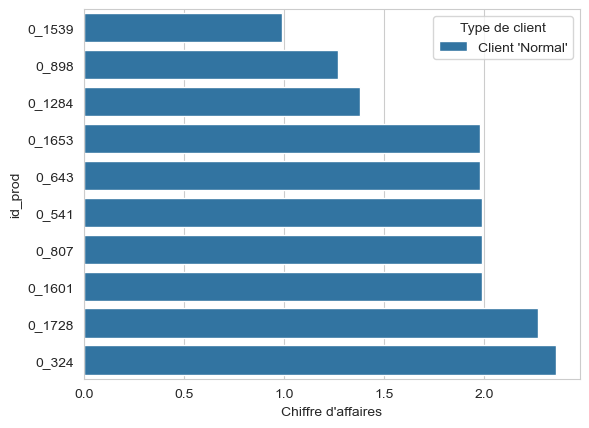

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


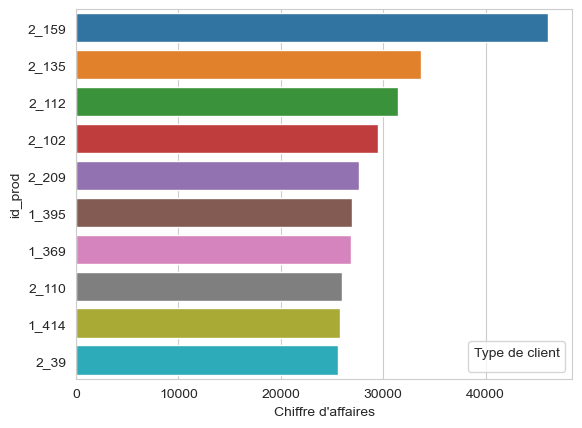

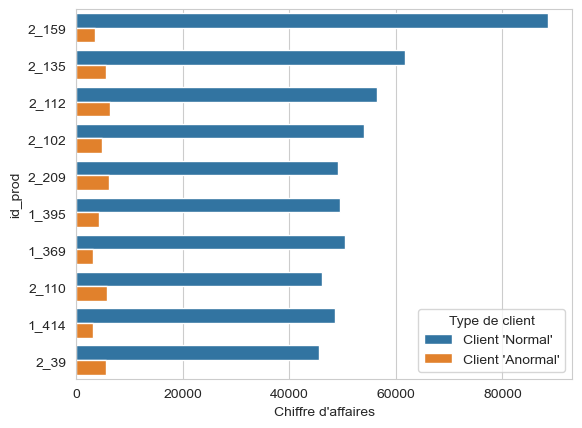

In [109]:

# Calcul du chiffre d'affaire par produit en fonction du type de client
chiffreAffaireProduit = tableTotale.copy(deep=True)
chiffreAffaireProduit.set_index('date')
chiffreAffaireProduit.index = pd.to_datetime(chiffreAffaireProduit.index)
chiffreAffaireProduit = chiffreAffaireProduit.groupby(['id_prod','anormal']).sum().reset_index().sort_values(by='price').rename(columns={"price": "Chiffre d'affaires"})

chiffreAffaireProduit['SumAll'] = chiffreAffaireProduit["Chiffre d'affaires"].groupby(chiffreAffaireProduit['id_prod']).transform('sum')
print(chiffreAffaireProduit.sort_values(by='id_prod'))

chiffreAffaireProduit = chiffreAffaireProduit.sort_values(by='SumAll')
sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduit.head(10), hue='anormal')
plt.legend(title='Type de client')
plt.savefig(urlFig + "Produits les moins rentables.png", dpi=300)
plt.show()



chiffreAffaireProduit = chiffreAffaireProduit.sort_values(by='SumAll',ascending=False)
sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduit.head(20), ci=None)
plt.legend(title='Type de client')

plt.savefig(urlFig + "Produits les plus rentables.png", dpi=300)
plt.show()


chiffreAffaireProduit = chiffreAffaireProduit.sort_values(by='SumAll',ascending=False)
sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduit.head(20), hue='anormal')
plt.legend(title='Type de client')

plt.savefig(urlFig + "Produits les plus rentables (normaux et anormaux séparés).png", dpi=300)


Nombre d'achats en fonction du prix

Index(['id_prod', 'categ', 'price', 'sex', 'nombre de ventes'], dtype='object')


<AxesSubplot:xlabel='price', ylabel='nombre de ventes'>

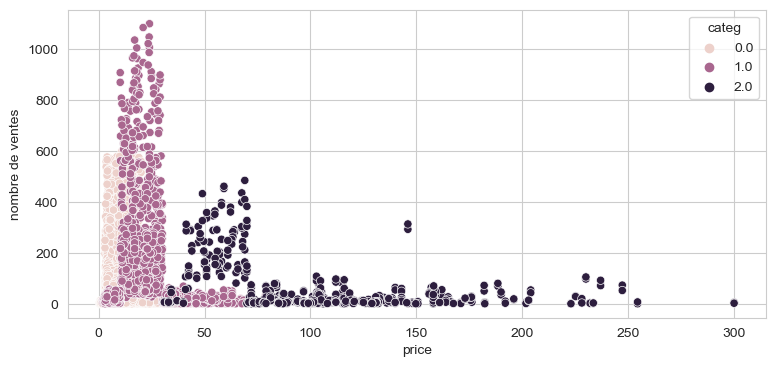

In [47]:
df = tableTotaleNormal[['id_prod','categ','price','jour','sex']].groupby(by=['id_prod','categ','price','sex']).count().rename(columns={'jour': "nombre de ventes"}).reset_index()
print(df.columns)
# sns.lmplot(data=df, x="price", y="nombre de ventes", hue="categ", col="sex")
plt.figure(figsize=(9,4))
sns.scatterplot(data=df, x="price", y="nombre de ventes", hue="categ")

# Répartition des clients

Courbe de Lorenz

In [48]:
# Fonction courbe de Lorenz
def lorenz(variable, title, ax):
    X = variable.values
    X = np.sort(X)

    # Indice de Gini
    def gini(array):
        sorted_array = array.copy()
        sorted_array.sort()
        n = array.size
        coef_ = 2. / n
        const_ = (n + 1.) / n
        weighted_sum = sum([(i + 1) * yi for i, yi in enumerate(sorted_array)])
        return coef_ * weighted_sum / (sorted_array.sum()) - const_

    print('Incide de Gini :', gini(X))

    # Courbe de Lorenz
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    # X_lorenz[0], X_lorenz[-1]
    y = np.arange(X_lorenz.size) / (X_lorenz.size - 1)
    lorenz = pd.DataFrame()
    lorenz['X'] = pd.Series(X_lorenz)
    lorenz['Y'] = pd.Series(y)
    sns.scatterplot(data=lorenz, x='Y', y='X', marker='x', ax=ax)

    # Diagonale
    a = np.arange(0, 1, .01)
    x = a
    y = a

    # Graphique
    sns.lineplot(x=x, y=y, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set(xlabel=title)


Incide de Gini : 0.40372319291525693
Incide de Gini : 0.44739817096802437


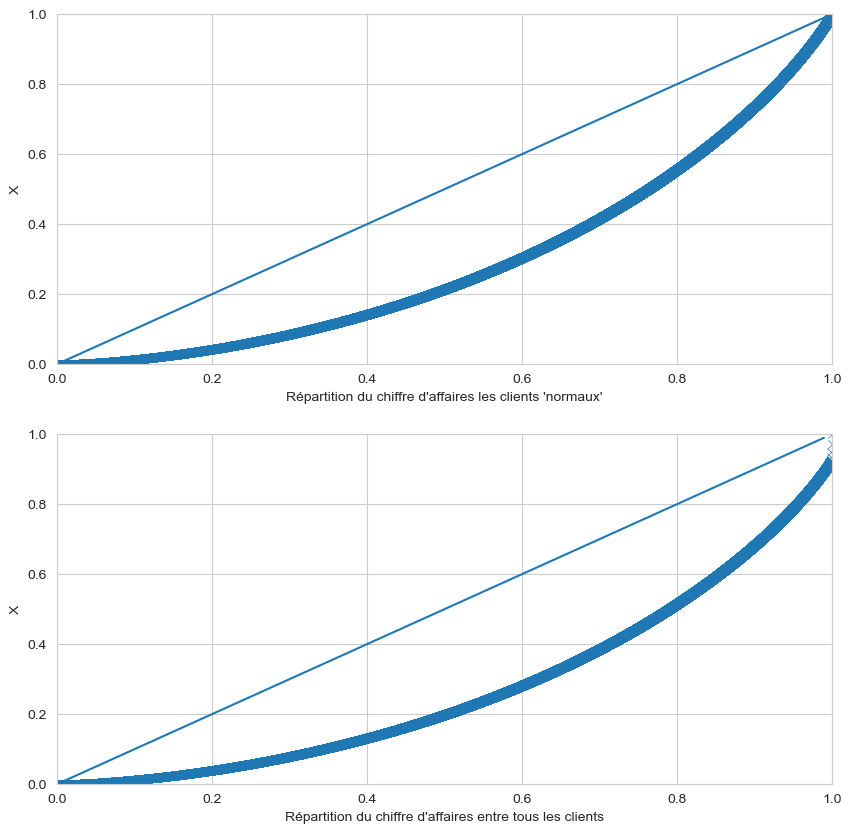

In [49]:
# Affichage des courbes de Lorenz
chiffreAffaireClient = tableTotale.groupby('client_id')['price'].sum().rename('chiffre d\'affaire').sort_values()
chiffreAffaireClientNormaux = tableTotaleNormal.groupby('client_id')['price'].sum().rename('chiffre d\'affaire').sort_values()

fig, (ax1,ax2) = plt.subplots(2, figsize=(10,10))

lorenz(chiffreAffaireClientNormaux, 'Répartition du chiffre d\'affaires les clients \'normaux\'', ax1)
lorenz(chiffreAffaireClient, 'Répartition du chiffre d\'affaires entre tous les clients', ax2)

plt.savefig(urlFig + "Courbes de Lorenz.png", dpi=300)

# Corrélation entre les caractéristiques

Test de Pearson entre les variables quantitatives

Index(['id_prod', 'date', 'session_id', 'client_id', 'price', 'categ', 'sex',
       'birth', 'age', 'trancheAge', 'montantPanierMoyen', 'taillePanierMoyen',
       'chiffreAffaireClient', 'jour', 'nombre d'achats', 'date_inscription',
       'ventes_mensuelles', 'nomférié', 'férié', 'saison', 'anormal'],
      dtype='object')


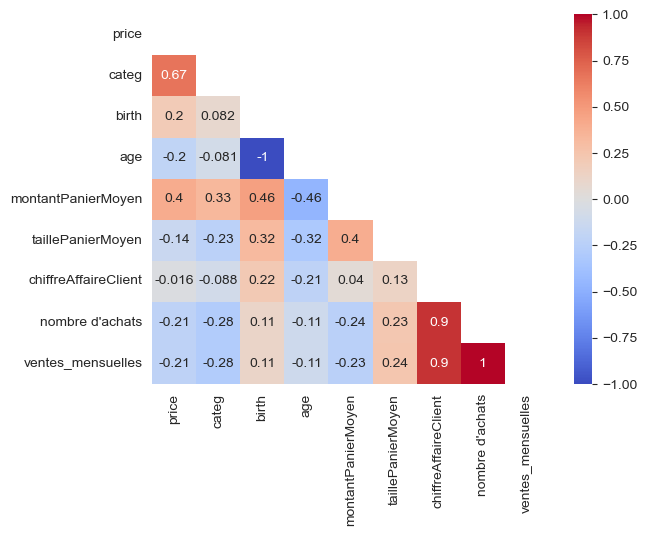

In [50]:
# Calcul des coefficients de Pearson entre les caractéristiques
print(tableTotale.columns)

mask = np.triu(np.ones_like(tableTotaleNormal.corr()))

sns.heatmap(tableTotaleNormal.corr(method='pearson'),vmin=-1,vmax=1, annot = True, mask=mask, fmt='.2g',cmap= 'coolwarm')

plt.savefig(urlFig + "Corrélation de pearson.png", dpi=300)

Test Chi² entre les variables qualitatives

In [51]:
Lqualitative = ['categ', 'sex', 'trancheAge' , 'jour', 'férié', 'saison']
Lquantitative = ['price', 'age', 'montantPanierMoyen', 'taillePanierMoyen', 'chiffreAffaireClient', "nombre d'achats", 'ventes_mensuelles']

In [80]:
crosstab, test_results, expected = rp.crosstab(tableTotaleNormal['categ'], tableTotaleNormal['trancheAge'], test= "chi-square", expected_freqs= True, prop= "cell")
print(test_results)

                 Chi-square test      results
0  Pearson Chi-square ( 16.0) =   247413.2018
1                     p-value =        0.0000
2                  Cramer's V =        0.4494


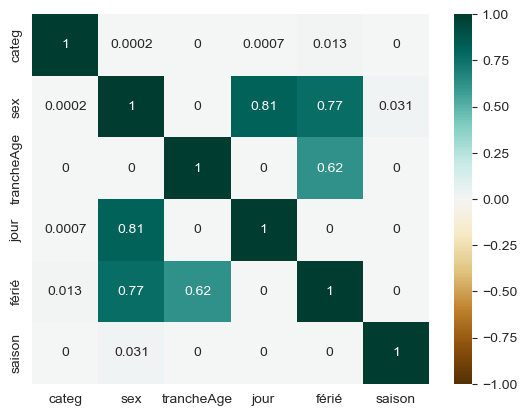

"\nif p > .05:\n    print('H0: the two samples are independent')\nelse:\n    print('H1: there is a dependency between the samples.')\nprint('\nConditions :\n'\n      '- Observations used in the calculation of the contingency table are independent.',\n      '\n- 25 or more examples in each cell of the contingency table.')\n\n\nH0 : Variables indépendantes si p-value > 5%\nH1 : Variables non indépendantes si p-value < 5%\n\nPhi and Cramer's V\tInterpretation\n>0.25\tVery strong\n>0.15\tStrong\n>0.10\tModerate\n>0.05\tWeak\n>0\tNo or very weak\n\n"

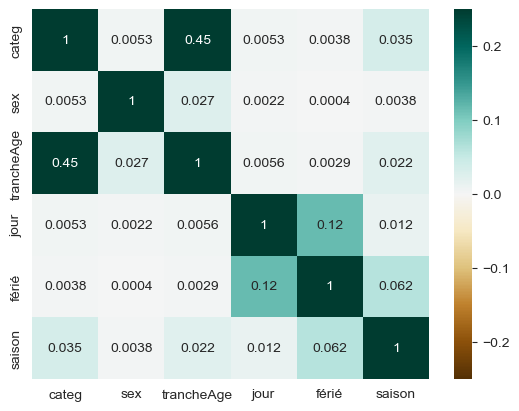

In [52]:
import scipy.stats as stats
import researchpy as rp

Lqualitative = ['categ', 'sex', 'trancheAge' , 'jour', 'férié', 'saison']

def tabChi2(df, Lqualitative):
    tabp = pd.DataFrame(index=Lqualitative)
    tabphi = pd.DataFrame(index=Lqualitative)
    lphi=[]
    lp=[]
    for i in Lqualitative:
        for j in Lqualitative:
            if i!=j:
                crosstab, test_results, expected = rp.crosstab(df[i], df[j], test= "chi-square", expected_freqs= True, prop= "cell")
                lp.append(test_results.loc[1,'results'])
                lphi.append(test_results.loc[2,'results'])
            else:
                lp.append(1)
                lphi.append(1)
        tabp[i] = lp
        tabphi[i] = lphi
        lphi=[]
        lp=[]
    return tabp, tabphi


tabp, tabphi = tabChi2(tableTotaleNormal[tableTotaleNormal['trancheAge']!='90-100'],Lqualitative)


sns.heatmap(tabp, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.savefig(urlFig + "Corrélation Chi² p-value.png", dpi=300)
plt.show()
sns.heatmap(tabphi, vmin=-0.25, vmax=0.25, annot=True, cmap='BrBG')
plt.savefig(urlFig + "Corrélation Chi² Phi.png", dpi=300)


"""
if p > .05:
    print('H0: the two samples are independent')
else:
    print('H1: there is a dependency between the samples.')
print('\nConditions :\n'
      '- Observations used in the calculation of the contingency table are independent.',
      '\n- 25 or more examples in each cell of the contingency table.')


H0 : Variables indépendantes si p-value > 5%
H1 : Variables non indépendantes si p-value < 5%

Phi and Cramer's V	Interpretation
>0.25	Very strong
>0.15	Strong
>0.10	Moderate
>0.05	Weak
>0	No or very weak

"""

Test Anova entre les variables qualitatives et quantitatives

(612421, 20)


<AxesSubplot:>

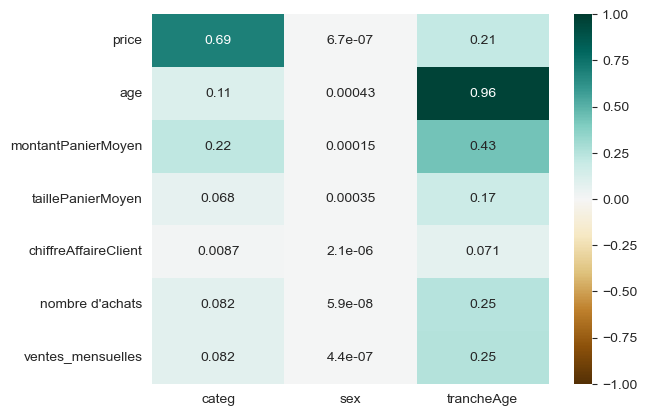

In [81]:
Lqualitative = ['categ', 'sex', 'trancheAge' ]
Lquantitative = ['price', 'age', 'montantPanierMoyen', 'taillePanierMoyen', 'chiffreAffaireClient', "nombre d'achats", 'ventes_mensuelles']

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

def tabAnova(df, Lqualitative, Lquantitative):
    tab = pd.DataFrame(index=Lquantitative)
    df1 = df.copy(deep=True)
    l=[]
    for i in Lqualitative:
        for j in Lquantitative:

            if j in ['montantPanierMoyen','taillePanierMoyen','chiffreAffaireClient',"nombre d'achats",'ventes_mensuelles']:
                df1 = df1.drop_duplicates(subset=['client_id'])

            elif (i,j) == ('categ','price') :
                df1 = df1.drop_duplicates(subset=['id_prod'])
            l.append(eta_squared(df1[i],df1[j]))
            df1 = df.copy(deep=True)

        tab[i] = l
        l=[]

    return tab

sns.heatmap(tabAnova(tableTotaleNormal,Lqualitative,Lquantitative), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.savefig(urlFig + "Corrélation Anova.png", dpi=300)

Test de Student entre le sexe et le nombre d'achats

In [107]:
# Vérification des hypothèses
# Loi normale
from scipy.stats import shapiro
for i in Lquantitative:
    dfm = tableTotaleNormal.loc[tableTotaleNormal['sex']=='m',i].sample(5000)
    dff = tableTotaleNormal.loc[tableTotaleNormal['sex']=='f',i].sample(5000)
    stat,pm = shapiro(dfm)
    stat,pf = shapiro(dff)
    if (pm>=0.05) or (pf>=0.05):
        print(i,"homme :",pm)
        print(i,"femme :",pf)
    else:
        print("\"",i,"\""," n'est pas distribué selon une loi normale", sep = '')
print("---------------------------------")
# Égalité des variances
from statistics import pvariance
for i in Lquantitative:
    vm = pvariance(dfm)
    vf = pvariance(dff)
    print(i,"homme :",vm,"femme :",vf)

"price" n'est pas distribué selon une loi normale
"age" n'est pas distribué selon une loi normale
"montantPanierMoyen" n'est pas distribué selon une loi normale
"taillePanierMoyen" n'est pas distribué selon une loi normale
"chiffreAffaireClient" n'est pas distribué selon une loi normale
"nombre d'achats" n'est pas distribué selon une loi normale
"ventes_mensuelles" n'est pas distribué selon une loi normale
---------------------------------
price homme : 14.1237979759 femme : 14.2597145575
age homme : 14.1237979759 femme : 14.2597145575
montantPanierMoyen homme : 14.1237979759 femme : 14.2597145575
taillePanierMoyen homme : 14.1237979759 femme : 14.2597145575
chiffreAffaireClient homme : 14.1237979759 femme : 14.2597145575
nombre d'achats homme : 14.1237979759 femme : 14.2597145575
ventes_mensuelles homme : 14.1237979759 femme : 14.2597145575


# Corrélation entre l'âge et les autres caractéristiques

On commence par étudier combien il y a de clients par tranche d'âge.

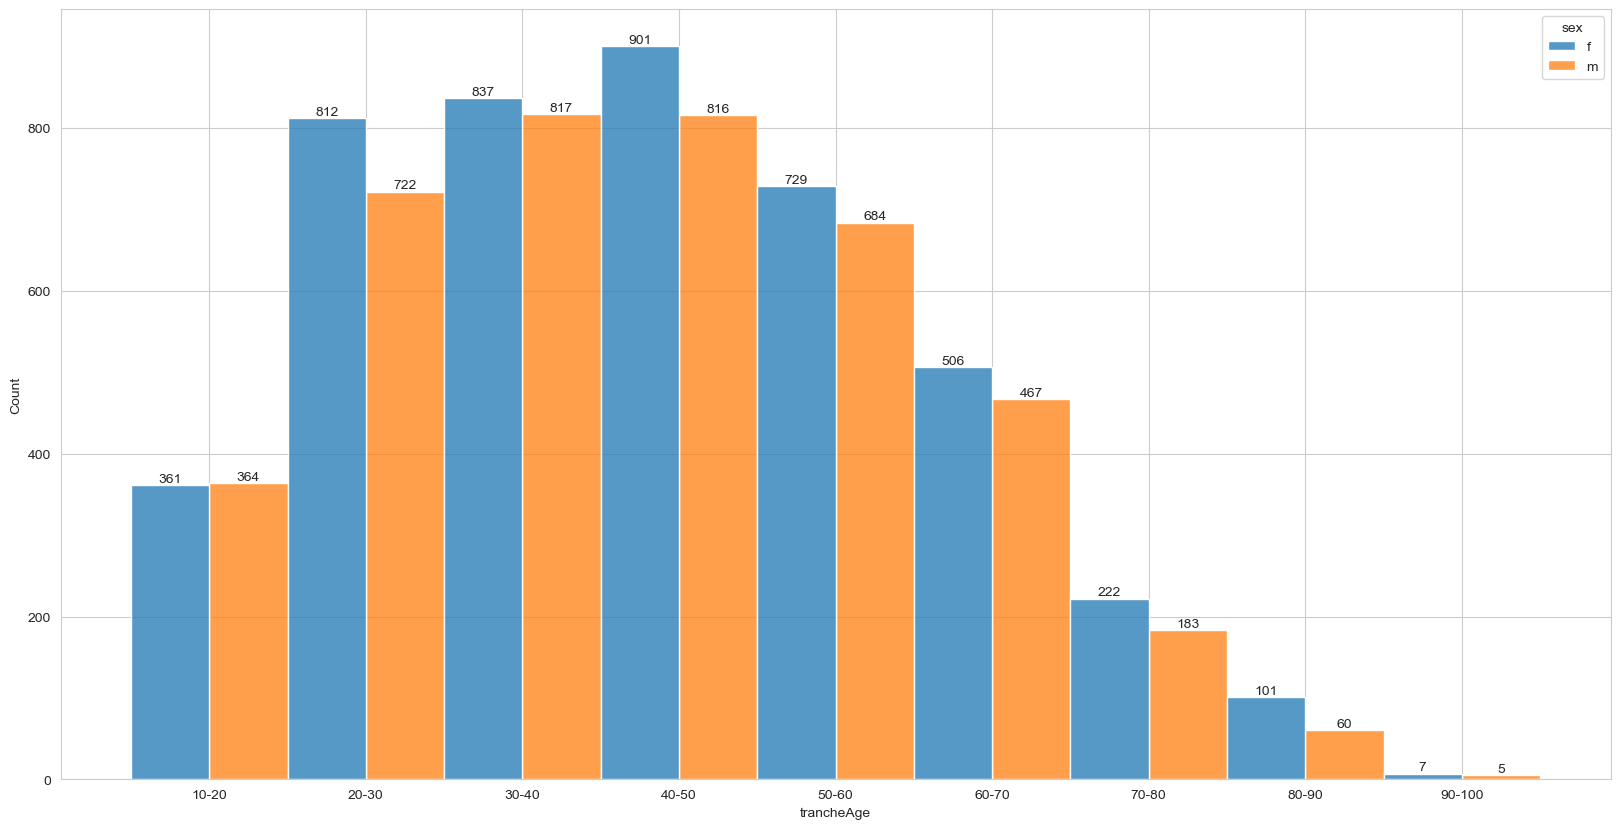

In [56]:
# Vérification du nombre d'individus par tranche d'âge
data = tableTotaleNormal.groupby(by='client_id').mean().merge(tableTotale[['sex','client_id']], how='inner', on='client_id').drop_duplicates()
data['age'] = data['age'].apply(int)
data['trancheAge'] = data['age'].apply(arrondiNInf,n=inter).apply(str)+'-'+(data['age'].apply(arrondiNInf,n=inter)+inter).apply(str)

plt.figure(figsize=(20,10))
ax = sns.histplot(data=data.sort_values(by='age'), x='trancheAge', hue='sex', multiple='dodge')

for container in ax.containers:
    ax.bar_label(container)

plt.savefig(urlFig + "Histogramme de la répartition de l'âge.png", dpi=300)

On remarque que la catégorie est 90-100 n'est pas représenté dans nos clients. Et qu'il y a autant d'hommes que de femmes dans chaque tranche d'âge.

Le coefficient de pearson entre l'âge et le nombre d'achats (ou de ventes) est très faible (0.02), ce qui laisse sous-entendre qu'il ni a pas de corrélation entre ces deux caractéristiques. Vérifions cela à l'aide de diagramme en boite en prenant le soin d'exclure les 4 clients anormaux.

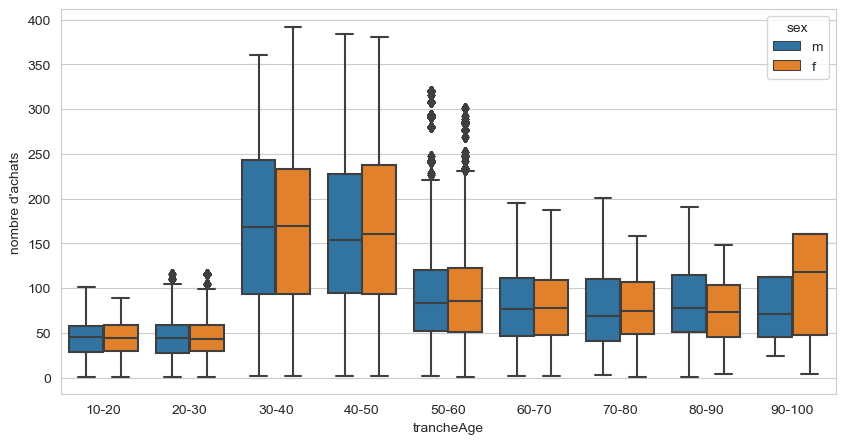

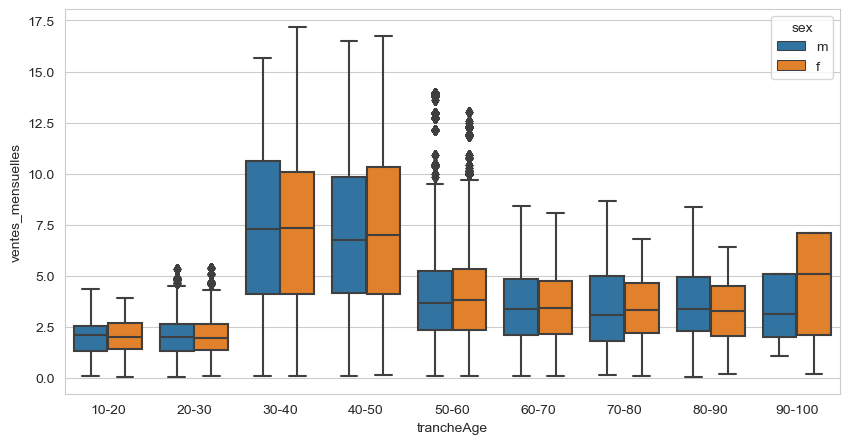

In [57]:
# Affichage de la fréquence d'achats en fonction de l'âge et du sexe
plt.figure(figsize=(10,5))
sns.boxplot(data=tableTotaleNormal.sort_values(by='age'), x='trancheAge', y="nombre d'achats",hue='sex')
plt.savefig(urlFig + "Nombre d'achats par tranche d'âge.png", dpi=300)
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(data=tableTotaleNormal.sort_values(by='age'), x='trancheAge', y="ventes_mensuelles",hue='sex')
plt.savefig(urlFig + "Ventes mensuelles par tranche d'âge.png", dpi=300)

Voyons maintenant la taille moyenne du panier et son montant moyen par âge

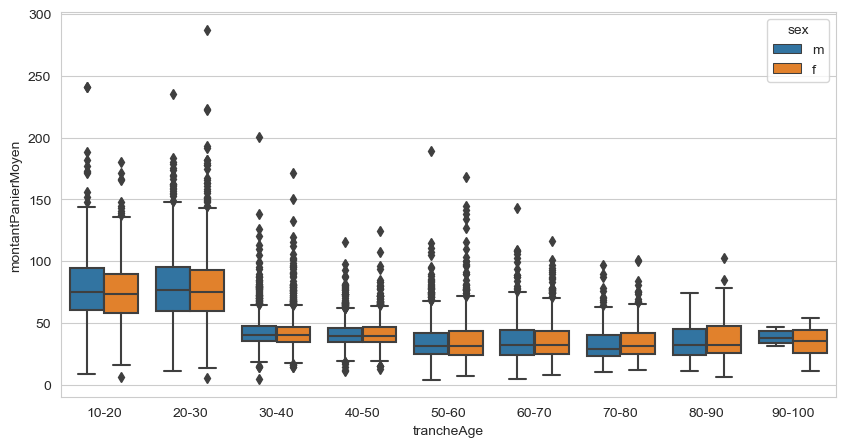

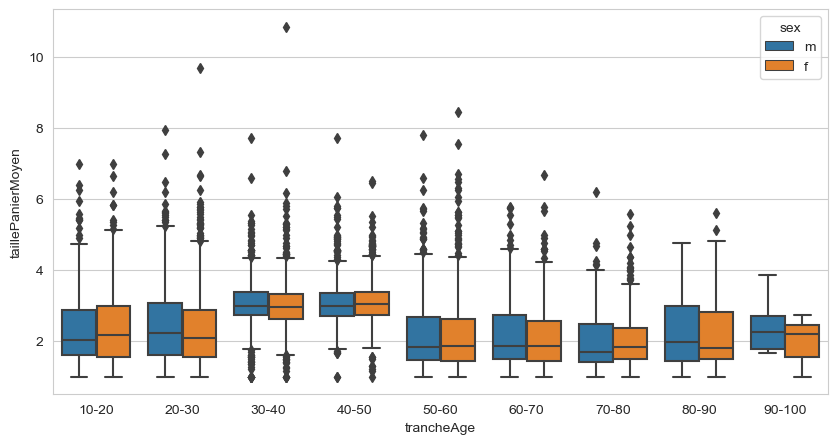

In [58]:
# Affichage de la taille et du montant moyen du panier en fonction de la tranche d'âge
plt.figure(figsize=(10,5))
sns.boxplot(data=tableTotaleNormal.drop_duplicates(subset=['client_id']).sort_values(by='age'), x='trancheAge', y="montantPanierMoyen",hue='sex')
plt.savefig(urlFig + "Montant moyen du panier par tranche d'âge.png", dpi=300)


plt.figure(figsize=(10,5))
sns.boxplot(data=tableTotaleNormal.drop_duplicates(subset=['client_id']).sort_values(by='age'), x='trancheAge', y="taillePanierMoyen",hue='sex')
plt.savefig(urlFig + "Taille moyenne du panier par tranche d'âge.png", dpi=300)


On peut remarquer que les 30-50 ans sont les clients avec le panier le plus garni en moyenne. Ils ont cependant des paniers relativement peu chers en moyenne si on tient compte de cette taille.

On va ensuite s'intéresser à la relation entre l'âge, le sexe et la catégorie du livre acheté.

<Figure size 3000x1500 with 0 Axes>

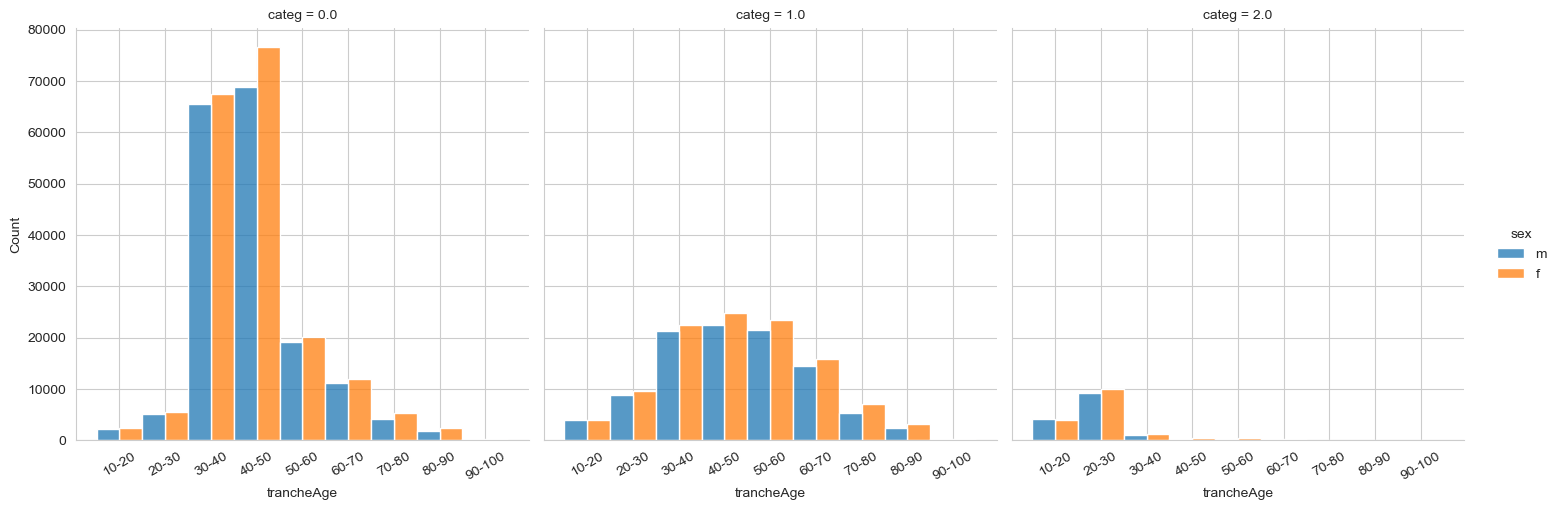

In [59]:
# Affichage du nombre d'achats dans chaque catégorie en fonction de l'âge et du sexe
plt.figure(figsize=(30,15))
sns.displot(data=tableTotaleNormal.sort_values(by='age'), x='trancheAge', hue='sex',multiple='dodge',col='categ').set_xticklabels(rotation=30)

plt.savefig(urlFig + "Nombre d'achats par tranche d'âge, sexe et catégorie.png", dpi=300)



Grâce à ces graphiques, on peut se rendre compte que le sexe n'a presque aucune incidence sur le comportement d'achat du client (Cp = 0.04). Au contraire, la catégorie achetée à un lien très faible avec l'âge.

Voyons plus en détail la relation entre l'âge et la catégorie achetée.

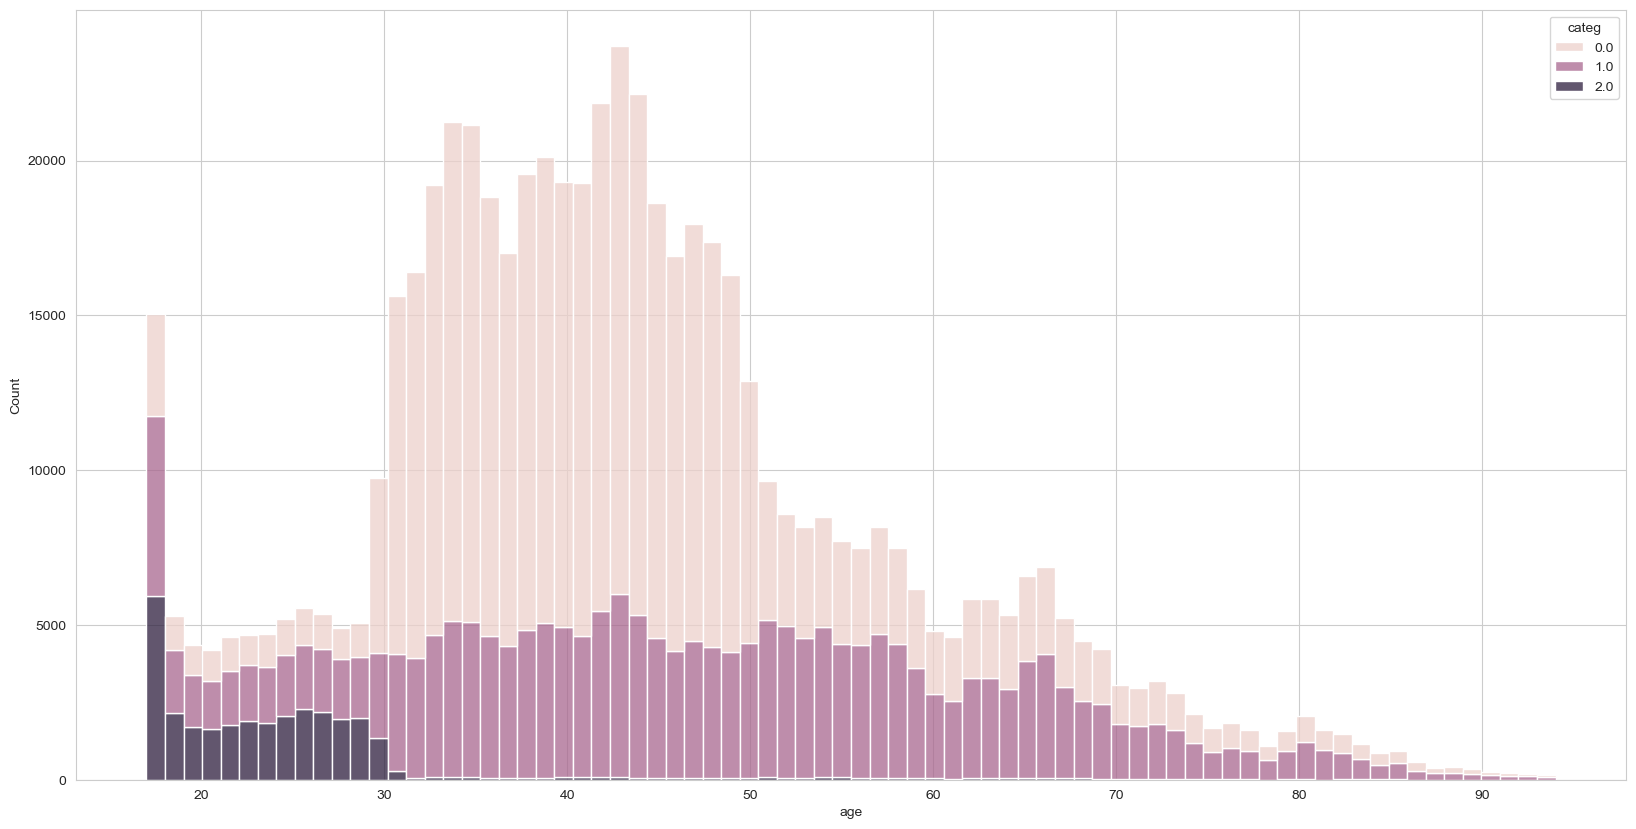

In [60]:
# Affichage du nombre de ventes par catégorie et par âge
plt.figure(figsize=(20,10))
sns.histplot(data=tableTotaleNormal.sort_values(by='age'), x='age', hue='categ',multiple='stack',bins=93-17)
plt.savefig(urlFig + "Proportion d'achats de catégorie par âge.png", dpi=300)


On peut voir plus facilement la répartition des catégories par tranche d'âge grâce à ce graphique, les 10-30 ans achètent environ autant de chaque catégorie, tandis que les 30+ n'achètent presque aucun livre de la deuxième catégorie.

Voyons maintenant la corrélation entre l'âge et le prix du livre acheté moyen.

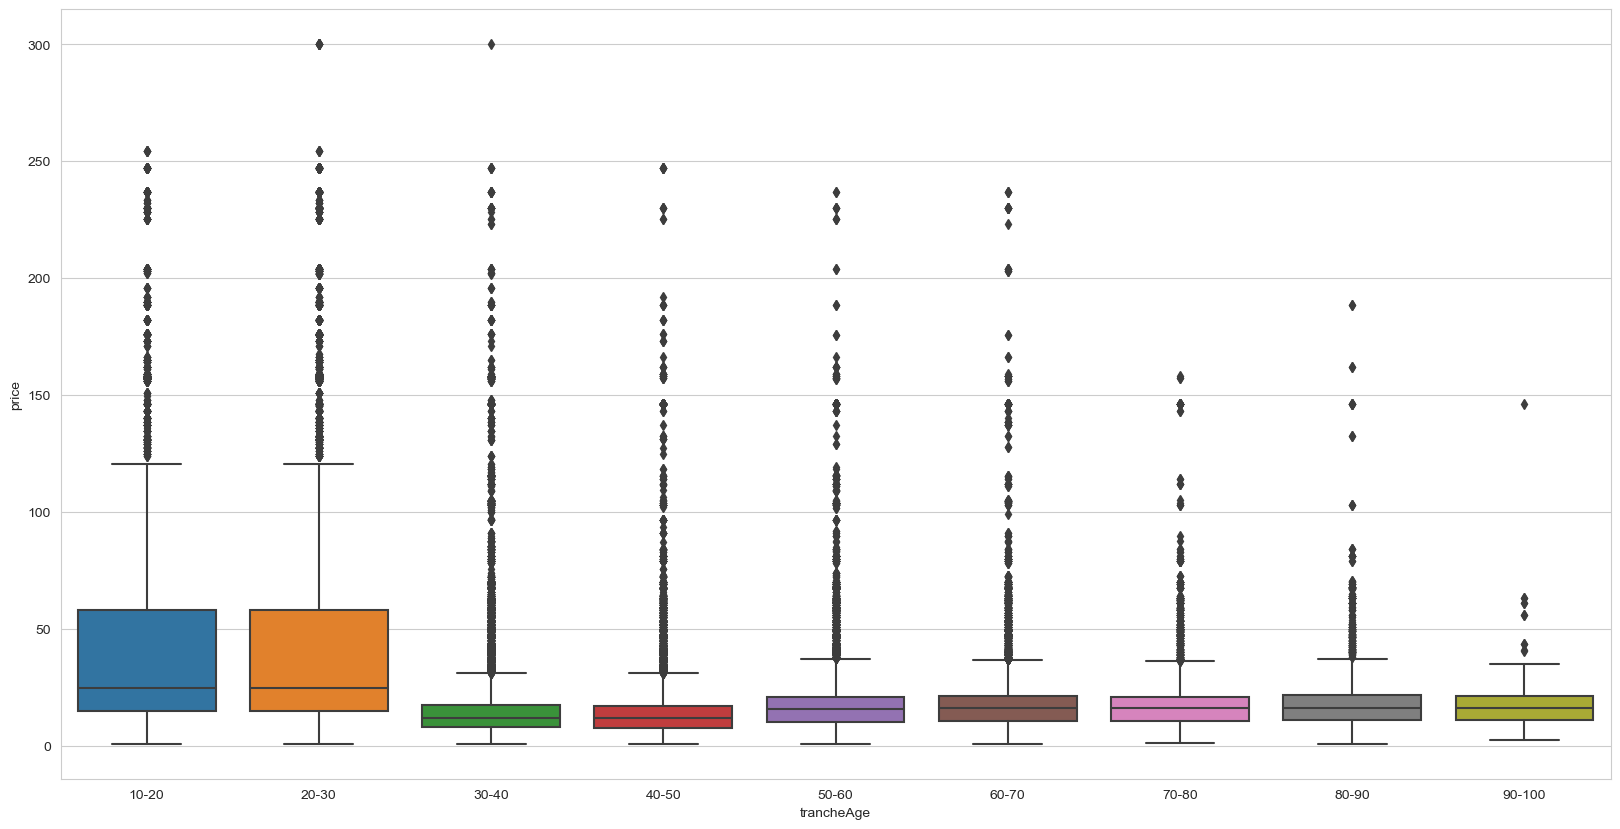

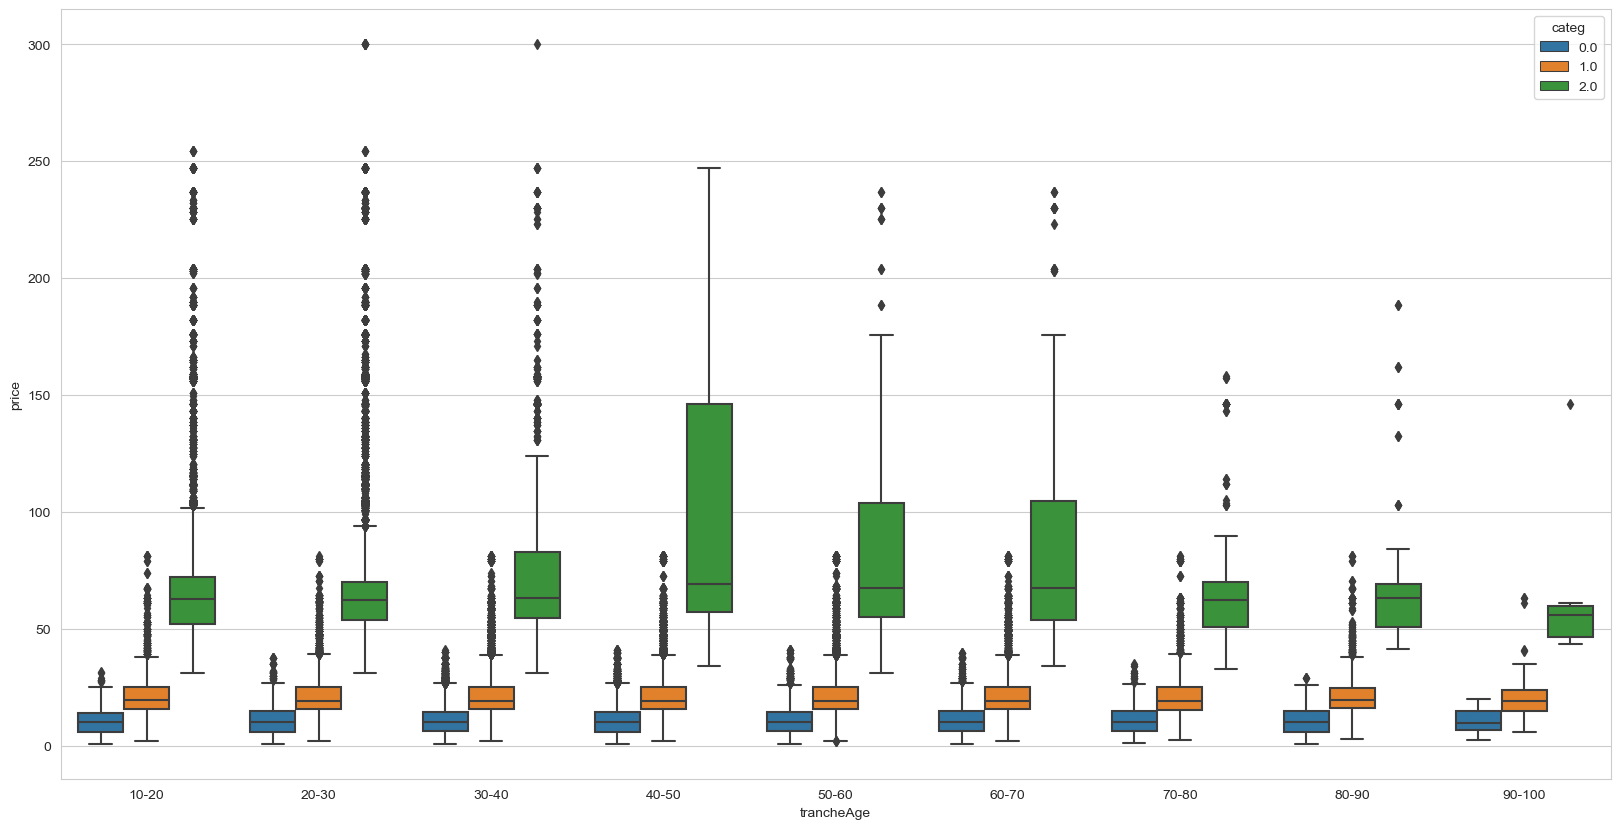

In [61]:
# Affichage du prix moyen du livre acheté en fonctionde l'âge (et de la catégorie)
plt.figure(figsize=(20,10))
sns.boxplot(data=tableTotaleNormal.sort_values(by='age'), x='trancheAge', y='price')
plt.savefig(urlFig + "Montant moyen du livre acheté par tranche d'âge.png", dpi=300)


plt.figure(figsize=(20,10))
sns.boxplot(data=tableTotaleNormal.sort_values(by='age'), x='trancheAge', y='price', hue='categ')
plt.savefig(urlFig + "Montant moyen du livre acheté par tranche d'âge et catégorie.png", dpi=300)


On peut remarquer que les 10-30 ans achètent des livres aux prix moyens les plus élevés. Mais on se rend compte sur le deuxième graphique que cet ecart est due à la différence du prix moyen entre chaque catégorie.

# Corrélation entre le prix et la catégorie

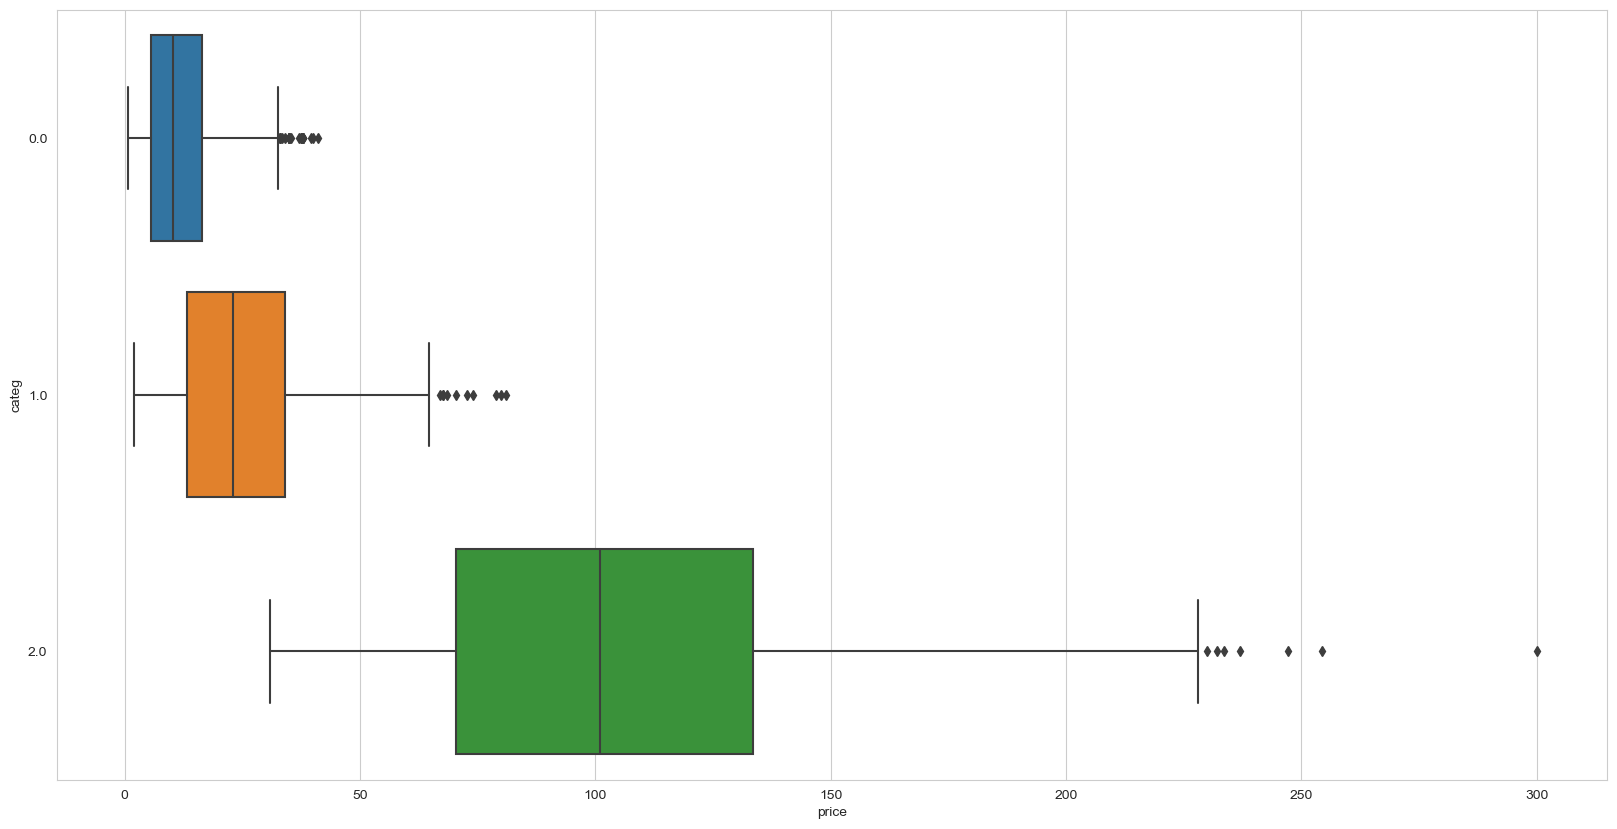

In [62]:
# Affichage du prix en fonction de la catégorie
plt.figure(figsize=(20,10))
sns.boxplot(data=tableTotaleNormal.drop_duplicates(subset=['id_prod']).sort_values(by='categ'), x='price', y='categ', orient='h')

plt.savefig(urlFig + "Montant moyen des livres par catégorie.png", dpi=300)

On peut remarquer que la catégorie 2 est bien plus chère en moyenne que les deux autres.

# Achats en fonction du jour de la semaine

In [63]:
tableTotaleNormal

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,trancheAge,montantPanierMoyen,taillePanierMoyen,chiffreAffaireClient,jour,nombre d'achats,date_inscription,ventes_mensuelles,nomférié,férié,saison
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,f,1986,36,30-40,33.51,2.85,2118.62,Friday,181,2021-04-04 05:48:00.482557,7.81,Aucun,Aucun,Printemps
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1.0,m,1988,34,30-40,44.55,2.90,3389.69,Wednesday,241,2021-04-07 11:27:39.031057,10.45,Aucun,Aucun,Hiver
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,69.99,2.0,m,2000,21,20-30,72.46,1.43,664.53,Thursday,14,2021-04-21 02:54:28.780319,0.62,Aucun,Aucun,Été
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,4.99,0.0,m,1980,43,40-50,38.74,2.73,2286.88,Wednesday,163,2021-04-03 22:59:43.064902,7.03,Aucun,Aucun,Hiver
5,0_1418,2022-10-20 15:59:16.084030,s_285425,c_1478,8.57,0.0,f,1972,50,50-60,44.45,3.20,3876.10,Thursday,286,2021-04-01 01:32:47.336658,12.29,Aucun,Aucun,Automne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657507,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,12.99,0.0,f,1951,71,70-80,27.65,1.89,1082.76,Saturday,72,2021-04-02 02:47:43.012785,3.10,Aucun,Aucun,Hiver
657508,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,10.99,1.0,f,1977,45,40-50,63.14,4.23,1170.78,Saturday,83,2021-04-21 06:16:20.489213,3.67,Aucun,Aucun,Printemps
657509,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,12.99,0.0,f,1988,34,30-40,44.50,3.07,1673.07,Tuesday,115,2021-04-14 22:42:12.073579,5.04,Aucun,Aucun,Hiver
657510,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,4.98,0.0,m,1986,35,30-40,37.24,2.87,2955.01,Friday,225,2021-04-04 19:17:57.245366,9.71,Aucun,Aucun,Été


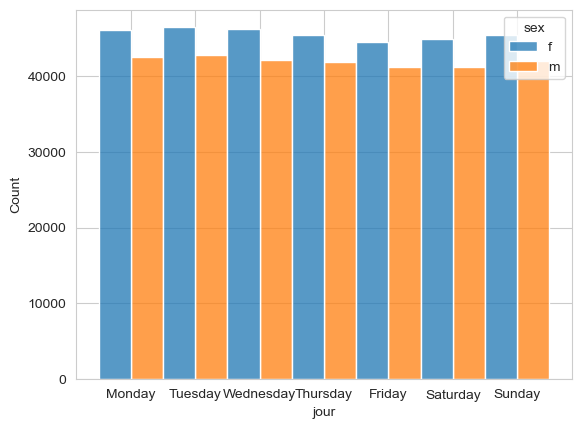

In [64]:
sns.histplot(data=tableTotaleNormal.sort_values(by='date'), x='jour', hue='sex', multiple='dodge')
tableTotaleNormal.sort_values(by='date').groupby(by='jour')['session_id'].nunique()
plt.savefig(urlFig + "Nombre d'achats par jour et sexe.png", dpi=300)

# Influence de ces différentes caractéristiques sur le chiffre d'affaires

In [65]:
data

,client_id,price,categ,birth,age,montantPanierMoyen,taillePanierMoyen,chiffreAffaireClient,nombre d'achats,ventes_mensuelles,sex,trancheAge
0,c_1,14.478684,0.263158,1955.0,66,26.56,1.63,550.19,38.0,1.91,m,60-70
38,c_10,23.337931,0.724138,1956.0,65,49.35,2.24,1353.60,58.0,2.57,m,60-70
96,c_100,31.856250,0.875000,1992.0,29,64.76,2.00,254.85,8.0,0.37,m,20-30
104,c_1000,18.114098,0.655738,1966.0,55,34.92,1.89,2209.92,122.0,5.34,f,50-60
226,c_1001,17.917500,0.343750,1982.0,39,61.37,2.92,1720.08,96.0,4.16,m,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...
612158,c_995,13.529286,0.214286,1955.0,66,22.06,1.71,189.41,14.0,0.64,m,60-70
612172,c_996,17.144574,0.585106,1970.0,51,23.43,1.34,1611.59,94.0,4.04,f,50-60
612266,c_997,24.690000,0.844828,1994.0,27,66.15,3.14,1432.02,58.0,2.72,f,20-30
612324,c_998,52.450566,1.264151,2001.0,20,133.59,4.32,2779.88,53.0,2.33,m,20-30


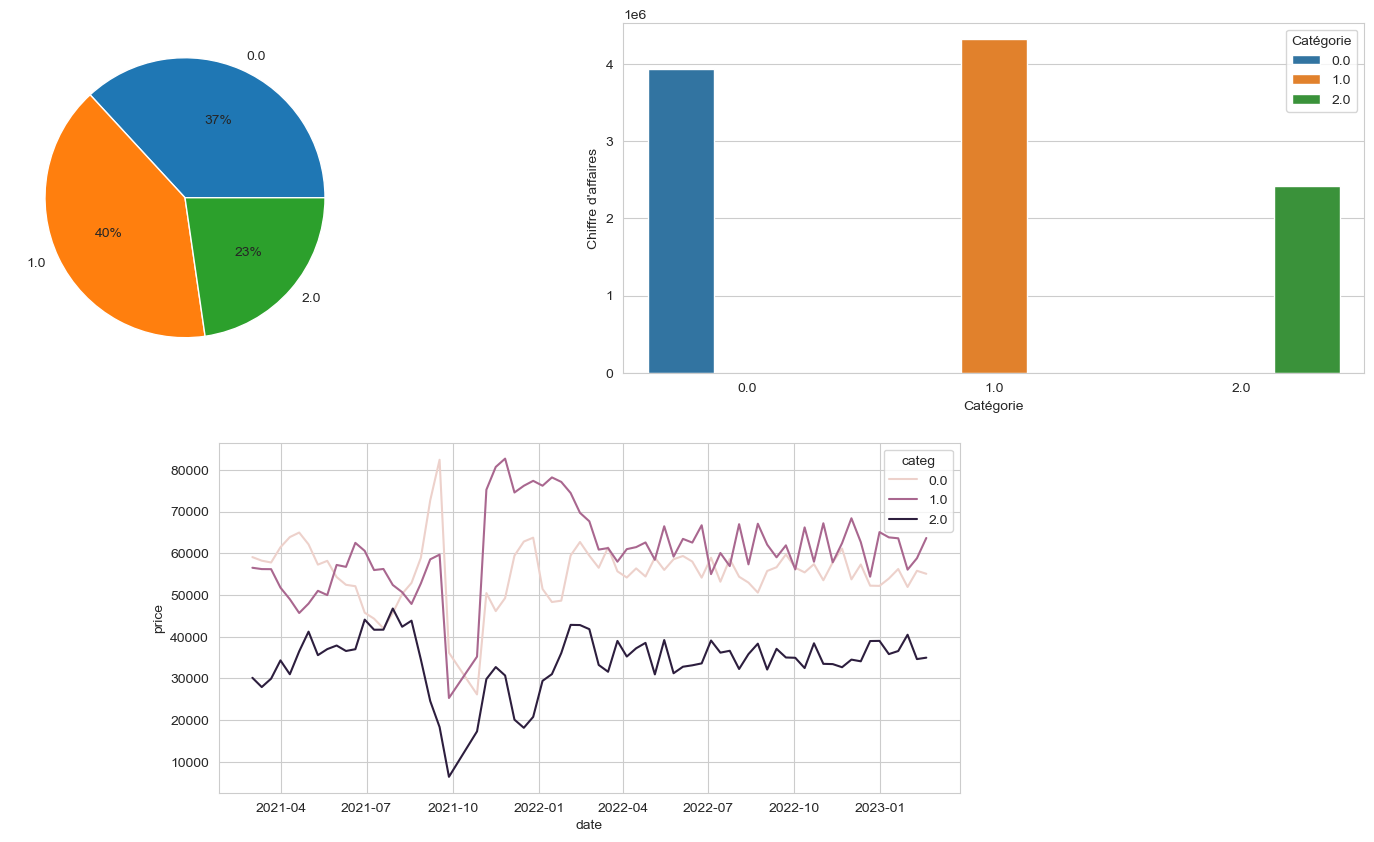

In [66]:

chiffreAffaireCategorie = tableTotaleNormal.groupby(by=[pd.Grouper(key='date', freq='10D'), 'categ'])['price'].sum().reset_index()#.unstack(fill_value=0)


data = chiffreAffaireCategorie.groupby(by='categ')['price'].sum().reset_index().rename(columns={'categ': 'Catégorie', 'price': "Chiffre d'affaires"})


fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((2,4),(0,0), colspan=2)
ax2 = plt.subplot2grid((2,4),(0,2), colspan=2)
ax3 = plt.subplot2grid((2,4),(1,1), colspan=2)


ax1.pie(data["Chiffre d'affaires"], labels=data["Catégorie"], autopct='%.0f%%')

sns.barplot(data=data, x='Catégorie', y="Chiffre d'affaires", hue='Catégorie', ax=ax2)

sns.lineplot(data=chiffreAffaireCategorie, hue='categ', x='date', y='price', ax=ax3)

plt.savefig(urlFig + "Chiffre d'affaires par catégorie.png", dpi=300)

Voyons le chiffre d'affaires par jour de la semaine et par catégorie

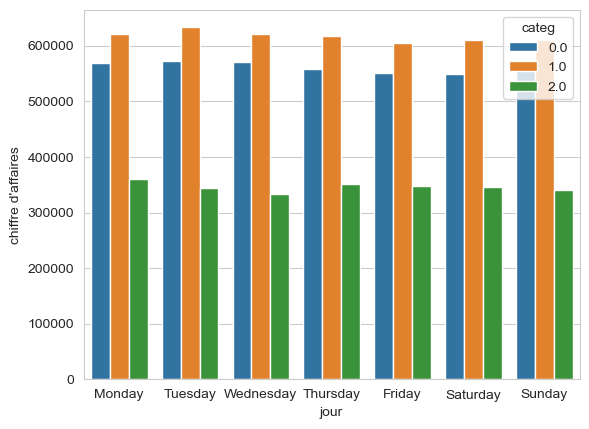

In [67]:
chiffreAffaireJour = tableTotaleNormal.groupby(by=['jour', 'categ'])['price'].sum().reset_index().rename(columns={'price': "chiffre d'affaires"})
sns.barplot(data=chiffreAffaireJour, x='jour', y="chiffre d'affaires", hue='categ')

plt.savefig(urlFig + "Chiffre d'affaires par catégorie et par jour.png", dpi=300)

Voyons le chiffre d'affaires par jour de la semaine et par tranche d'âge

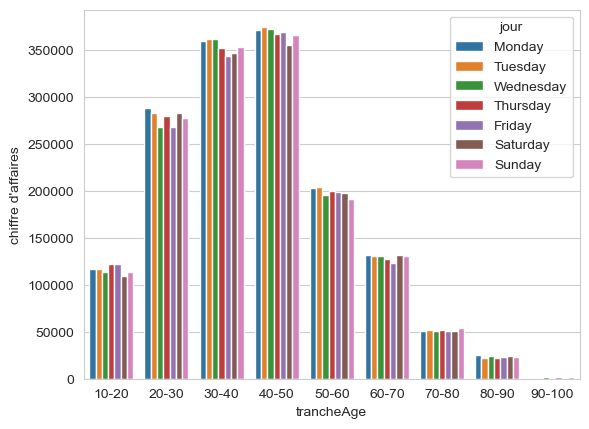

In [68]:
chiffreAffaireJour = tableTotaleNormal.sort_values(by='jour').groupby(by=['jour', 'trancheAge'])['price'].sum().reset_index().rename(columns={'price': "chiffre d'affaires"})
sns.barplot(data=chiffreAffaireJour, x='trancheAge', y="chiffre d'affaires", hue='jour',hue_order=Ljour)
plt.savefig(urlFig + "Chiffre d'affaires par tranche d'âge et par jour.png", dpi=300)

Voyons le nombre d'achats par jour de la semaine et par tranche d'âge

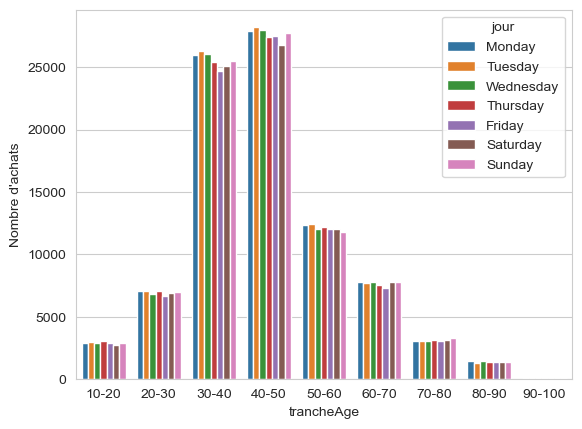

In [69]:
# Nombre d'achats par jour de la semaine et par tranche d'âge
nbAchatsJour = tableTotaleNormal.sort_values(by='jour').groupby(by=['jour', 'trancheAge'])['price'].count().reset_index().rename(columns={'price': "Nombre d'achats"})
sns.barplot(data=nbAchatsJour, x='trancheAge', y="Nombre d'achats", hue='jour', hue_order=Ljour)
plt.savefig(urlFig + "Nombre d'achats par tranche d'âge et par jour.png", dpi=300)

Chiffre d'affaires par tranche d'âge et par saison

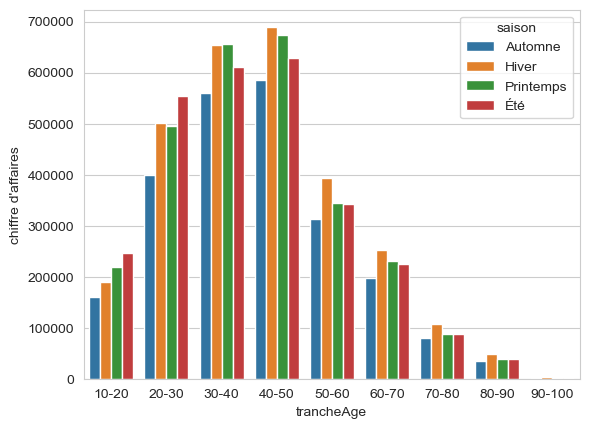

In [70]:
chiffreAffaireJour = tableTotaleNormal.groupby(by=['saison', 'trancheAge'])['price'].sum().reset_index().rename(columns={'price': "chiffre d'affaires"})
sns.barplot(data=chiffreAffaireJour, x='trancheAge', y="chiffre d'affaires", hue='saison')

plt.savefig(urlFig + "Chiffre d'affaires par tranche d'âge et par saison.png", dpi=300)

Nombre d'achats par tranche d'âge et par saison

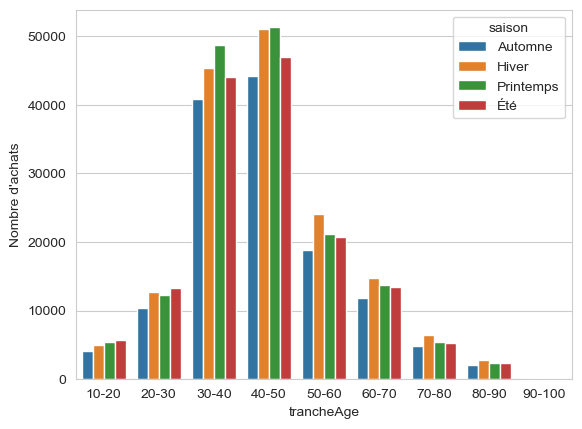

In [71]:
# Nombre d'achats par tranche d'âge et par saison

nbAchatsJour = tableTotaleNormal.groupby(by=['saison', 'trancheAge'])['price'].count().reset_index().rename(columns={'price': "Nombre d'achats"})
sns.barplot(data=nbAchatsJour, x='trancheAge', y="Nombre d'achats", hue='saison')

plt.savefig(urlFig + "Nombre d'achats par tranche d'âge et par saison.png", dpi=300)

Chiffre d'affaires par catégorie et par saison

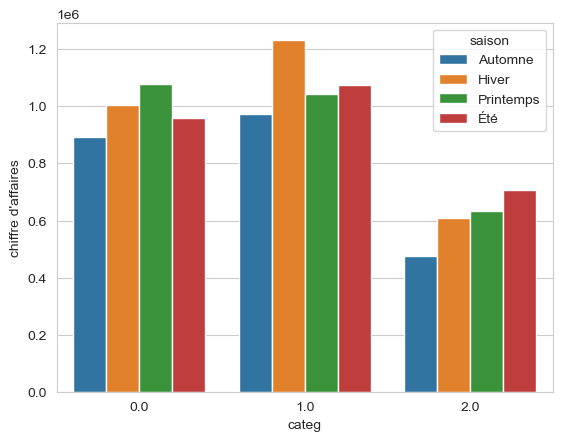

In [72]:
chiffreAffaireJour = tableTotaleNormal.groupby(by=['saison', 'categ'])['price'].sum().reset_index().rename(columns={'price': "chiffre d'affaires"})
sns.barplot(data=chiffreAffaireJour, x='categ', y="chiffre d'affaires", hue='saison')

plt.savefig(urlFig + "Chiffre d'affaires par catégorie et par saison.png", dpi=300)

Nombre d'achats par saison et catégorie

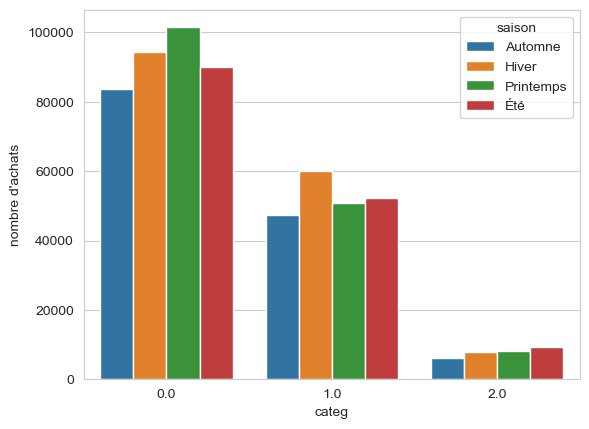

In [73]:
# Nombre d'achats par saison et catégorie

nbAchatJour = tableTotaleNormal.groupby(by=['saison', 'categ'])['price'].count().reset_index().rename(columns={'price': "nombre d'achats"})
sns.barplot(data=nbAchatJour, x='categ', y="nombre d'achats", hue='saison')

plt.savefig(urlFig + "Nombre d'achats par catégorie et par saison.png", dpi=300)



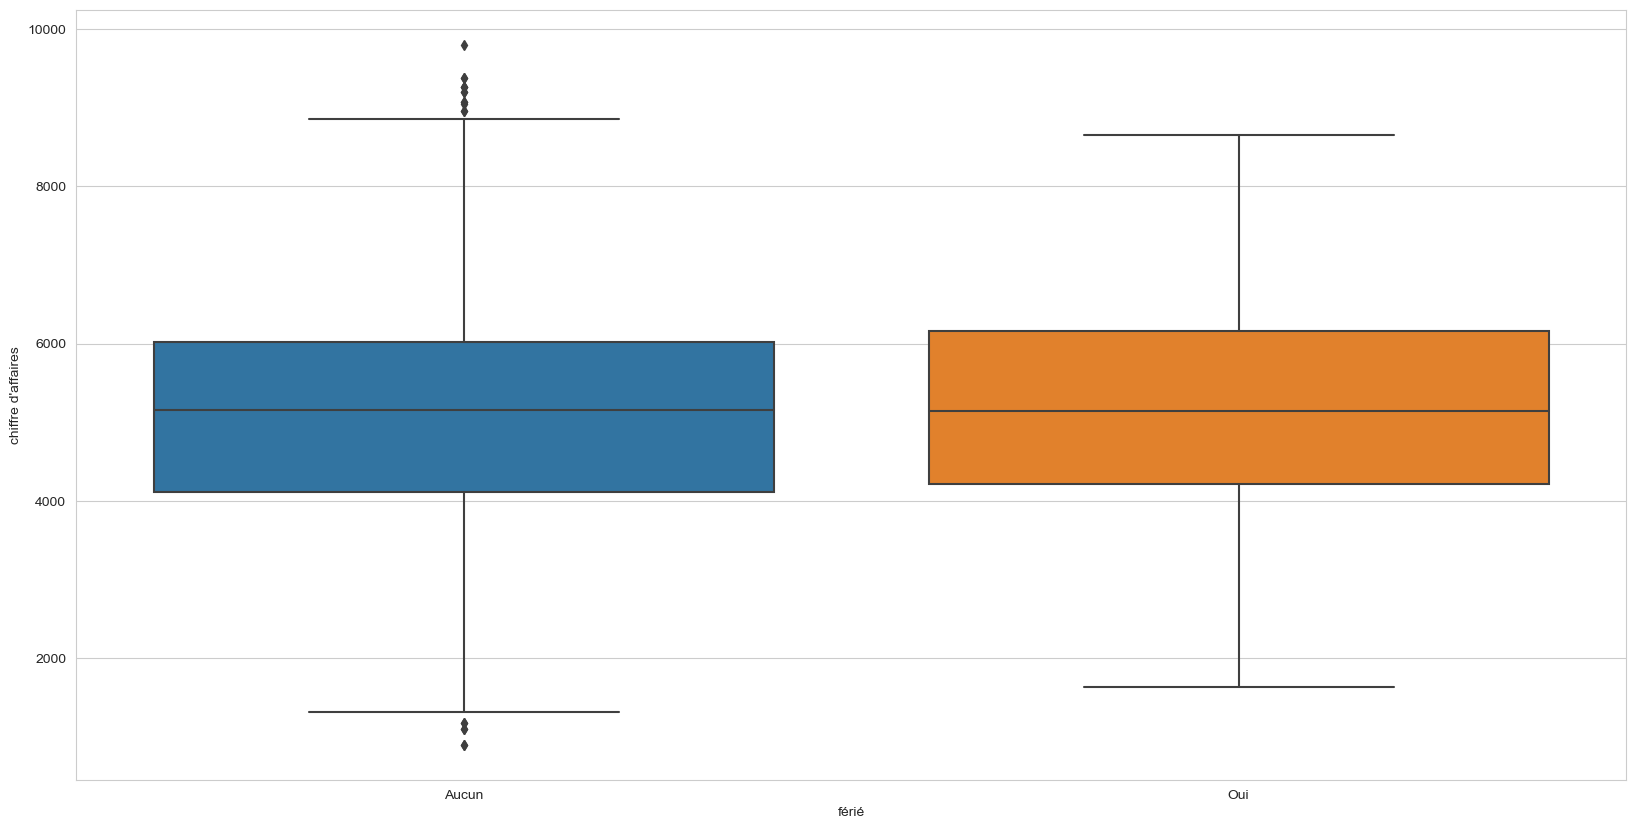

In [74]:
chiffreAffaireJour = tableTotaleNormal[tableTotaleNormal['férié']!='Aucun'].groupby(by=['férié', 'categ'])['price'].sum().reset_index().rename(columns={'price': "chiffre d'affaires"})
plt.figure(figsize=(20,10))
# sns.barplot(data=chiffreAffaireJour, x='categ', y="chiffre d'affaires", hue='férié')

chiffreAffaireCategorie = tableTotaleNormal.groupby(by=[pd.Grouper(key='date', freq='D'), 'categ', 'férié'])['price'].sum().reset_index().rename(columns={'price': "chiffre d'affaires"})
sns.boxplot(data=chiffreAffaireCategorie, y="chiffre d'affaires", x='férié')


plt.savefig(urlFig + "Chiffre d'affaires par catégorie et par jour férié.png", dpi=300)

Timestamp('2023-02-28 23:58:30.792755')